In [21]:
from scipy.fft import fft
from scipy.linalg import expm
import time
import random
import json
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.sparse as ss
from scipy.optimize import minimize
from entforg import *
from IPython.display import display,Markdown,Latex


from qiskit.primitives import StatevectorEstimator
from qiskit import transpile
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp, Operator
from qiskit.synthesis import MatrixExponential, LieTrotter
from qiskit_nature.second_q.hamiltonians import QuadraticHamiltonian
from qiskit_nature.second_q.operators import FermionicOp
from qiskit_nature.second_q.mappers import JordanWignerMapper
from itertools import product
import math

from qiskit.quantum_info.operators import Pauli
from qiskit_nature.second_q.mappers.fermionic_mapper import FermionicMapper

from collections import defaultdict 
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from IPython.display import display
ME = MatrixExponential()

!!!!!!!!!!!!!!!!!!!!

Incluye la obtención de los términos diagonales cuadráticos (energías orbitales) teniendo en cuenta lo que aporten a estos el cambio de base de los cuadráticos, así como el uso del Estimator (ideal) para el cálculo de las energías, la creación del hamiltoniano problema a partir de los shifts y J dados, o la representación gráfica del espectro. También se guardan los valores de energías y matrices de rotación para todos los betas.

También se realiza el truncamiento del espectro para el cálculo del valor esperado de H o de la energía libre.

!!!!!!!!!!!!!!!!!!!!

### Definimos las distintas funciones que nos permitirán llevar a cabo las optimizaciones.

In [22]:
# Estas son funciones para visualizar de una forma más agradable las matrices resultantes.
def MatrixToLatex(A):
    a="\\begin{bmatrix}"
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            if ((j+1)%A.shape[1])==0:           
                a=a+"{0:.2f}".format(A[i,j])
            else:
                a=a+"%s&"%"{0:.2f}".format(A[i,j])
        if ((i+1)%A.shape[0])!=0:
            a=a+"\\\\"
    a=a+"\\end{bmatrix}"

    return(a)

def Display(string):
    display(Markdown(string))

    
def DisplayMatrix(A):
    A_Latex = MatrixToLatex(A)
    display(Markdown(A_Latex))

In [23]:
# Esta función calcula el hamiltoniano del problema, dados los valores de los shifts y el offset en ppm, de los J en Hz y de B en MHz. 
def Hspin(shifts, J, offset, B):
    # Leemos cuantos spines hay en el sistema.
    n=len(shifts)
    # Definimos los coeficientes que acompañarán a las cadenas de Pauli.
    w=[(shifts[i]-offset)*np.pi*B for i in range(n)]
    J2=[np.pi*J[i]/2 for i in range(len(J))]
    # Creamos las listas que guardarán los datos.
    pauli_strings = []
    coeffs=[]
    # Añadimos los términos correspondientes a los shifts.
    for i in range(n):
        string='I'*i+'Z'+'I'*(n-i-1)
        pauli_strings.append(string)
        coeffs.append(w[i])
    # Añadimos los términos correspondientes a los J.
    k=0
    for i in range(n):
        for j in range(n-i-1):
            strX='I'*i+'X'+'I'*j+'X'+'I'*(n-i-j-2)
            strY='I'*i+'Y'+'I'*j+'Y'+'I'*(n-i-j-2)
            strZ='I'*i+'Z'+'I'*j+'Z'+'I'*(n-i-j-2)
            pauli_strings.append(strX)
            coeffs.append(J2[k])
            pauli_strings.append(strY)
            coeffs.append(J2[k])
            pauli_strings.append(strZ)
            coeffs.append(J2[k])
            k+=1
    # Creamos y devolvemos el operador equivalente en la base de Pauli
    return SparsePauliOp.from_list(list(zip(pauli_strings, coeffs))) 

           

In [24]:
# Función necesaria para transformar los nombres de los elementos del diccionario que guarda la descomposición en operadores fermiónicos.
def transform_dict_keys(data):
    label_transformation = {
        "I": "",
        "N": "+_{} -_{}",
        "E": "-_{} +_{}",
        "+": "+_{}",
        "-": "-_{}",
    }

    new_data = {}
    for key, value in data.items():
        new_key_parts = []
        for i, char in enumerate(key):
            if char in label_transformation:
                # Apply transformation if the character is in the mapping
                transformed = label_transformation[char].format(i, i)
                if transformed:
                    new_key_parts.append(transformed)
        new_key = ' '.join(new_key_parts)  # Join the parts with spaces
        new_data[new_key] = value

    return new_data

# Función que transforma un operador descompuesto en cadenas de Pauli en un operador en la base fermiónica. 
# Aplica la transformación de Jordan-Wigner inversa.
def reverse_map(second_q_op: SparsePauliOp) -> FermionicOp:
        """Maps a class:`OperatorBase` to a `FermionicOp`.

        Args:
            second_q_op: the :class:`OperatorBase` to be mapped.

        Returns:
            The `FermionicOp` corresponding to the Hamiltonian in the Fermionic space.
        """

        num_qubits = second_q_op.num_qubits # get number of qubits from input second quantized operator
        fermionic_op = None
        for term in second_q_op:
            transform_list : List[Tuple(str, float)] = []  # list of tuple(pauli, coeff)
            coef_term = term.coeffs[0]  # Assuming coeffs is a list with a single element
            target_pauli_op = term.paulis[0]
            #print(target_pauli_op)

            for i in range(num_qubits):
                one_pauli = target_pauli_op[num_qubits - 1 - i]
                pauli_char=one_pauli.to_label()
                if pauli_char == 'Z': # dealing Pauli Z op
                    transform_list.append((('I',1),('N', -2))) # Zj -> I - 2*Nj => [('I', 1), ('N', -2)]
                elif pauli_char == 'X': # dealing Pauli X op
                    transform_list.append((("+", 1), ('-', 1))) # Xj -> aj_dag + aj => [('+', 1), ('-', 1)]
                    target_pauli_op &= Pauli("I" * (i+1) + "Z" * (num_qubits - i - 1)) # apply Z(j-1)Z(j-2) ... Z(0)
                elif one_pauli.to_label() == 'Y': # dealing Pauli Y op
                    transform_list.append((('+', -1j), ('-', 1j))) # Yj -> i(aj - aj_dag) => [('+', -1j), ('-', 1j)]
                    target_pauli_op &= Pauli("I" * (i+1) + "Z" * (num_qubits - i - 1)) # apply Z(j-1)Z(j-2) ... Z(0)
                else: 
                    # dealing Pauli I op
                    transform_list.append((('I', 0.5), ('I', 0.5))) # Ij -> Ij => [('I', 0.5), ('I', 0.5)]; split I into 0.5I + 0.5I for code consistency
            
            # dealing the phase
            if target_pauli_op.phase == 1:
                coef_term *= -1j
            elif target_pauli_op.phase == 2:
                coef_term *= -1
            elif target_pauli_op.phase == 3:
                coef_term *= 1j

            #print(transform_list)
            pauli_coefs = []
            pauli_strings = []
            # create fermionic operator for a term based on transform_list
            for idxes in product(*[[0, 1]]*num_qubits):
                pauli_coefs.append(math.prod([t[i][1] for t, i in zip(transform_list, idxes)]))
                pauli_strings.append("".join([t[i][0] for t, i in zip(transform_list, idxes)])[::-1])
            ferm_op=list(zip(pauli_strings, pauli_coefs))

            ferm_dict = defaultdict(float)

            # Iterate over each tuple in the list
            for key, value in ferm_op:
                # Sum the float values for tuples with the same string
                ferm_dict[key] += value

            ferm_dict_sparse=transform_dict_keys(ferm_dict)

            #print(ferm_dict)
            #print(ferm_dict_sparse)
            #print(coef_term)

            if not fermionic_op:
                fermionic_op = coef_term * FermionicOp(ferm_dict_sparse,num_spin_orbitals=num_qubits).simplify()
            else:
                fermionic_op += coef_term * FermionicOp(ferm_dict_sparse,num_spin_orbitals=num_qubits).simplify()

        return fermionic_op.simplify()

# Función que filtra los términos con dos operadores fermiónicos.
def filter_two_operator_terms(fermionic_op):
    """
    Filtra los términos con exactamente dos operadores del FermionicOp.

    Args:
        fermionic_op (FermionicOp): El operador fermiónico a filtrar.

    Returns:
        FermionicOp: Un nuevo FermionicOp con solo los términos de dos operadores.
    """
    filtered_data = {
        term: coeff
        for term, coeff in fermionic_op.items()
        if len(term.split()) == 2 or len(term.split())==0   # Solo términos con dos operadores
    }
    return FermionicOp(filtered_data, num_spin_orbitals=fermionic_op.num_spin_orbitals)

In [25]:
# Función que realiza el cambio de base del operador fermiónico, dada una matriz de cambio de base T.
def transform_fermionic_op(fermionic_op, T, T_conj):
    new_op_data = {}
    
    for term, coeff in fermionic_op.items():
        # Ignorar el término constante
        if term == '':
            new_op_data[''] = coeff
            continue
        
        # Expandir cada término en la nueva base
        new_terms = {}
        for t in term.split():
            op, idx = t[0], int(t[2])
            if op == '+':  # Transformación de operadores de creación
                new_operators = {f'+_{j}': T[j, idx] for j in range(len(T))}
            elif op == '-':  # Transformación de operadores de destrucción
                new_operators = {f'-_{j}': T_conj[j, idx] for j in range(len(T_conj))}
            
            # Combinar términos en la nueva base
            if not new_terms: # Si este término no existía, simplemente se guarda el nuevo.
                new_terms = new_operators
            else: # Si existía, se combinan los antiguos con los nuevos de esta iteración.
                new_terms = {
                    f"{k1} {k2}": v1 * v2
                    for k1, v1 in new_terms.items()
                    for k2, v2 in new_operators.items()
                }
        
        # Agregar al nuevo FermionicOp
        for new_term, new_coeff in new_terms.items():
            if new_term in new_op_data:
                new_op_data[new_term] += coeff * new_coeff
            else:
                new_op_data[new_term] = coeff * new_coeff

    return FermionicOp(new_op_data, num_spin_orbitals=len(T))


In [26]:
def filter_single_z_terms(sparse_pauli_op):
    """
    Filtra los términos en un SparsePauliOp que contienen exactamente una 'Z' y el resto son identidades ('I').

    Args:
        sparse_pauli_op (SparsePauliOp): El SparsePauliOp a filtrar.

    Returns:
        SparsePauliOp: Un nuevo SparsePauliOp con los términos filtrados.
    """
    pauli_strings = sparse_pauli_op.paulis.to_labels()
    coeffs = sparse_pauli_op.coeffs

    # Filtrar términos con exactamente una 'Z' y el resto 'I'
    filtered_pauli_strings = []
    filtered_coeffs = []
    
    for pauli, coeff in zip(pauli_strings, coeffs):
        if pauli.count('Z') == 1 and pauli.count('I') == len(pauli) - 1:
            filtered_pauli_strings.append(pauli)
            filtered_coeffs.append(coeff)
        if pauli.count('I') == len(pauli):
            filtered_pauli_strings.append(pauli)
            filtered_coeffs.append(coeff)

    # Crear y devolver el nuevo SparsePauliOp con los términos filtrados
    return SparsePauliOp.from_list(list(zip(filtered_pauli_strings, filtered_coeffs)))

In [27]:
# Función que calcula el valor esperado de la energía del hamiltoniano total.
def expectation_classic(x, ansatz_U, beta, m, H_matrix, H_tot_matrix, cllbck = None):
    U_bound = ansatz_U.assign_parameters(x) # Dado un vector de parámetros, los asigna al operador unitario equivalente al circuito.
    U_matrix = Operator(U_bound).data # Obtenemos la matriz de este operador.

    # Obtenemos las energías como el valor esperado de H en el circuito que aplica U para cada vector de la base computacional.
    qclist=[]
    n=len(U_matrix)
    N_sites=int(np.log2(n))
    obs=SparsePauliOp.from_operator(Operator(H_matrix))
        
    for i in range(m):
        # Construimos el circuito
        qc=QuantumCircuit(N_sites)
        qc.initialize(i)
        qc=qc.compose(U_bound)
        # Añadimos a la lista el circuito con el observable.
        qclist.append((qc,obs))

    # Para calcular el valor esperado, necesitamos el Estimator.
    estimator = StatevectorEstimator()
    job = estimator.run(qclist)
    Energies=np.zeros(m)
    for i in range(m):
        # Las energías se corresponden con los valores del observable para cada circuito.
        Energies[i]=job.result()[i].data.evs.item()
    
    # Obtenemos el TFD a partir de estas energías y de la matriz U.
    TFD, _ = get_TFD_trunc(beta, U_matrix, np.conj(U_matrix), Energies,mask=range(m))
    sTFD = ss.csr_matrix(TFD)
    # Obtenemos el valor esperado de la energía del hamiltoniano total en el estado dado por el TFD obtenido.
    total_energy = np.real(np.dot(np.conj(sTFD), np.dot(H_tot_matrix, sTFD.T)))[0,0]
    
    if cllbck is not None:
        cllbck(x, U_matrix)
    return total_energy
    
def callback(x):
    global x_arr
    x_arr.append(x)

# Función que calcula el valor de la energía libre.
def free_energy(x, ansatz_U, beta, m, H_matrix, H_tot_matrix, cllbck = None):
    U_bound = ansatz_U.assign_parameters(x) # Dado un vector de parámetros, los asigna al operador unitario equivalente al circuito.
    U_matrix = Operator(U_bound).data # Obtenemos la matriz de este operador.

    # Obtenemos las energías como el valor esperado de H en el circuito que aplica U para cada vector de la base computacional.
    qclist=[]
    n=len(U_matrix)
    N_sites=int(np.log2(n))
    obs=SparsePauliOp.from_operator(Operator(H_matrix))
    for i in range(m):
        # Construimos el circuito
        qc=QuantumCircuit(N_sites)
        qc.initialize(i)
        qc=qc.compose(U_bound)
        # Añadimos a la lista el circuito con el observable.
        qclist.append((qc,obs))

    # Para calcular el valor esperado, necesitamos el Estimator.
    estimator = StatevectorEstimator()
    job = estimator.run(qclist)
    Energies=np.zeros(m)
    for i in range(m):
        # Las energías se corresponden con los valores del observable para cada circuito.
        Energies[i]=job.result()[i].data.evs.item()
        
    # Obtenemos el valor de la energía libre.
    energia_libre=-sum(np.exp(-beta*Energies))/beta
    
    if cllbck is not None:
        cllbck(x, U_matrix)
    return energia_libre

In [28]:
# Función que crea el circuito que usamos como ansatz.
def ansatz_U(qubit_op,N_sites, reps=1):
    ansatz_U = QuantumCircuit(N_sites) # Creamos nuestro circuito de N spines
    # Obtenemos los grupos de conmutación de nuestro operador de espines, así como los términos con un solo operador Z.
    groups=qubit_op.group_commuting()
    group_cuadratic=filter_single_z_terms(qubit_op)
    count = 0

    # Aplicamos tantas repeticiones como se nos diga del circuito. Primero, se aplican bloques correspondientes a todos los grupos de conmutación
    # y, después, se aplica un bloque extra correspondiente a los términos con un solo operador Z.
    for r in range(reps):
        for d in range(len(groups)):
            ansatz_U.append(PauliEvolutionGate(groups[len(groups)-d-1], Parameter('t['+ str(count) + ']'), synthesis=ME), range(N_sites))
            count += 1
        ansatz_U.append(PauliEvolutionGate(group_cuadratic, Parameter('t['+ str(count) + ']'), synthesis=ME), range(N_sites))
        count += 1
    return ansatz_U

In [ ]:
# Clases que nos permitirán representar el espectro, proporcionadas por Mestrelab.
class SpinSystem:
  def __init__(self):
    self.nucs = []
    self.jlist = []
    self.level =1
    
  def addNuc(self,name,shift):
      tn = nucleus(name,shift);
      self.nucs.append(tn)
      
  def addJ(self,name1,name2,j):
      tn = coupling(name1,name2,j);
      self.jlist.append(tn)
    
class nucleus:
    def __init__(self,name,shift):
      self.name = name
      self.shift = shift
      
class coupling:
    def __init__(self,name1,name2,j):
      self.name1 = name1
      self.name2=name2
      self.j = j
        
class NMRSimulator:
    E= np.matrix([[1, 0],[0, 1]])
    Ix = np.matrix([[0, 1/2],[1/2, 0]])
    Iy= np.matrix([[0, -1J/2], [1J/2, 0]])
    Iz = np.matrix([[1/2,0],[0,-1/2]])   
      
    def __init__(self):
      #std operators        
  

      # SET SIM parameters here
      self.field =400   
      self.swp = 10
      self.setOffsetPPM( 5)
      self.setTD(2**14)
      self.setT2(2);
      self.debug=False
      #self.noise=1/2000
      self.nucleus="1H"
      
    def setField(self,field):
        self.field=field
        self.offsetH = self.offset*self.field
        
    def setSWPPM(self,swp): 
        self.swp=swp
        self.swh=swp*self.field
        self.dw=1/self.swh
        
    def setOffsetPPM(self,offset):
        self.offset=offset
        self.offsetH = self.offset*self.field
        
    def setTD(self,td):
        self.td=int(td)
        
    def setT2(self, t2):
        self.t2=t2
      
    def getOperator (op, n):
        for i in range(n):
            if i==0:
                h=op
            else:
                h=NMRSimulator.E
            for j in range (1,n):
                if i==j:
                    h2=op
                else:
                    h2=NMRSimulator.E
                h=np.kron(h,h2)
            if(i==0):
                H=h
            else:
                H=H+h
        return H;
    
      
    def makeHamiltonian(self, ss):
        for n in ss.nucs:
            ind = ss.nucs.index(n)
            #print('nuc ' + n.name + ' ' +  str(ind))
            if ind==0:
                h=NMRSimulator.Iz
            else:
                h=NMRSimulator.E
            for i in range (1,len(ss.nucs)):
                if ind==i:
                    h2=NMRSimulator.Iz
                else:
                    h2=NMRSimulator.E
                h=np.kron(h,h2)
            h = h * np.pi*2 * (n.shift * self.field - self.offsetH)
            if(ind==0):
                H=h
            else:
                H=H+h
            
        #print('done nucs')
        for j in ss.jlist:
            ind1 = NMRSimulator.getIndexForName(j.name1, ss.nucs)
            ind2 = NMRSimulator.getIndexForName(j.name2, ss.nucs)
            #print (str(ind1) + '   ' + str(ind2))
            if ind1==0 or ind2==0:
                hx=NMRSimulator.Ix
                hy=NMRSimulator.Iy
                hz=NMRSimulator.Iz
                #print('ind0 hx')
            else:
                hx=NMRSimulator.E
                hy=NMRSimulator.E
                hz=NMRSimulator.E
                #print('ind0 E')
            for i in range (1,len(ss.nucs)):
                if ind1==i or ind2==i:
                    hx2=NMRSimulator.Ix
                    hy2=NMRSimulator.Iy
                    hz2=NMRSimulator.Iz
                    #print('indi hx')
                else:
                    hx2=NMRSimulator.E
                    hy2=NMRSimulator.E
                    hz2=NMRSimulator.E
                    #print('indi E')
                hx=np.kron(hx,hx2)
                hy=np.kron(hy,hy2)
                hz=np.kron(hz,hz2)
            H= H + 2*np.pi*j.j*(hx + hy + hz)
        return H

    def getIndexForName(name, nucs):
        for l in nucs:
            ind = nucs.index(l)
            if(l.name == name):
                return ind;
        

        
    def simSpinSystem(self, ss):
        H = self.makeHamiltonian(ss)
        m0 = NMRSimulator.getOperator(NMRSimulator.Ix,len(ss.nucs))
        IxT = m0
        IyT = NMRSimulator.getOperator(NMRSimulator.Iy,len(ss.nucs))
        vals,vecs = LA.eigh(H)
        vecsi = LA.inv(vecs)
        diag = np.diag(vals)
        fidr  = np.empty(self.td);
        fidi  = np.empty(self.td);
        t = np.empty(self.td);
        ff = self.t2/(2*np.pi)
        fac = ss.level / 2**len(ss.nucs)    
        mMat = vecsi * m0 * vecs
        if(self.debug):
            print('made matrices ' + str(time.process_time() - self.start))
        for x in range (self.td):
            t[x]=x*self.dw
            tm = vecs * expm(-1J*t[x]*diag) * mMat * expm(1J*t[x]*diag) * vecsi
            fac2 =  np.exp(-x*self.dw/ff) * fac
            fidr[x] = np.real(np.trace(tm*IxT) * fac2)
            fidi[x] = np.real(np.trace(tm*IyT) * fac2)
        if(self.debug):
            print('made fid ' + str(time.process_time() - self.start))
        return fidr,fidi,tm, vals, vecs
    
    def simSpinSystemQuantum(self, ss, vals, vecs):
        H = self.makeHamiltonian(ss)
        m0 = NMRSimulator.getOperator(NMRSimulator.Ix,len(ss.nucs))
        IxT = m0
        IyT = NMRSimulator.getOperator(NMRSimulator.Iy,len(ss.nucs))
        vecsi = LA.inv(vecs)
        diag = np.diag(vals)
        fidr  = np.empty(self.td);
        fidi  = np.empty(self.td);
        t = np.empty(self.td);
        ff = self.t2/(2*np.pi)
        fac = ss.level / 2**len(ss.nucs)    
        mMat = vecsi * m0 * vecs
        if(self.debug):
            print('made matrices ' + str(time.process_time() - self.start))
        for x in range (self.td):
            t[x]=x*self.dw
            tm = vecs * expm(-1J*t[x]*diag) * mMat * expm(1J*t[x]*diag) * vecsi
            fac2 =  np.exp(-x*self.dw/ff) * fac
            fidr[x] = np.real(np.trace(tm*IxT) * fac2)
            fidi[x] = np.real(np.trace(tm*IyT) * fac2)
        if(self.debug):
            print('made fid ' + str(time.process_time() - self.start))
        return fidr,fidi,tm, vals, vecs
    
#    def getNoise(self):
#        u = random.random(); 
#        v = random.random();
#        return math.sqrt(-2.0 * math.log(u)) * math.cos(2.0 * np.pi * v) * self.noise;
#    
#    def addNoise(self,re,im):
#        for i in range(len(re)):
#            re[i]=re[i]+self.getNoise()
#            im[i]=im[i]+self.getNoise()

    def simSpectrum(self, sss, sc=1.0, b=0.0):

        fidrSum  = np.zeros(self.td);
        fidiSum  = np.zeros(self.td);
        self.start = time.process_time()
        for ss in sss: 
            fidr,fidi,tm, vals, vecs = self.simSpinSystem(ss)
            fidrSum = fidr + fidrSum
            fidiSum = fidi + fidiSum
        
        fidrSum  = fidrSum * sc 
        fidiSum = fidiSum * sc
        
        #self.addNoise(fidrSum,fidiSum)
        spcr = fft(fidrSum)
        spci = fft(fidiSum)
        if(self.debug):
            print('done fft ' + str(time.process_time() - self.start))
        spc = spcr-1J*spci
        spcOut = np.empty(self.td);
        fs = np.empty(self.td);
        td2 =int(self.td/2)
        for i in range(td2):
            spcOut[td2+i]=np.real(spc[i])
            spcOut[i] =np.real(spc[td2+i])
            fs[i] = (1/self.dw/2 - i/td2/self.dw/2)/self.field + self.offset
            fs[self.td-i-1]=(-1/self.dw/2 + i/td2/self.dw/2) / self.field + self.offset
        if(self.debug):
            print('all done ' + str(time.process_time() - self.start))
        spcOut = spcOut - np.amin(spcOut)
        spcOut = spcOut + b
        return spcOut,fs, vals, vecs
    
    def simSpectrumQuantum(self, sss, vals, vecs, sc=1.0, b=0.0):

        fidrSum  = np.zeros(self.td);
        fidiSum  = np.zeros(self.td);
        self.start = time.process_time()
        for ss in sss: 
            fidr,fidi,tm, vals, vecs = self.simSpinSystemQuantum(ss, vals, vecs)
            fidrSum = fidr + fidrSum
            fidiSum = fidi + fidiSum
        
        fidrSum  = fidrSum * sc 
        fidiSum = fidiSum * sc
        
        #self.addNoise(fidrSum,fidiSum)
        spcr = fft(fidrSum)
        spci = fft(fidiSum)
        if(self.debug):
            print('done fft ' + str(time.process_time() - self.start))
        spc = spcr-1J*spci
        spcOut = np.empty(self.td);
        fs = np.empty(self.td);
        td2 =int(self.td/2)
        for i in range(td2):
            spcOut[td2+i]=np.real(spc[i])
            spcOut[i] = np.real(spc[td2+i])
            fs[i] = (1/self.dw/2 - i/td2/self.dw/2)/self.field + self.offset
            fs[self.td-i-1]=(-1/self.dw/2 + i/td2/self.dw/2) / self.field + self.offset
        if(self.debug):
            print('all done ' + str(time.process_time() - self.start))
        spcOut = spcOut - np.amin(spcOut)
        spcOut = spcOut + b
        return spcOut,fs, vals, vecs

In [30]:
# Definimos la función que representa el espectro obtenido frente al teórico.
def reprSpectrum(shifts,J,d,SW,B,offset,energ,U,xlim=None,ylim=None,reprteo=True):
    # Construimos el SpinSystem asociado, añadiendo los shifts primero y los acoplamientos J después.
    sscase = SpinSystem()
    n=len(shifts)
    for i in range(n):
        sscase.addNuc(str(i), shifts[i])
    k=0
    for i in range(n):
        for j in range(i+1,n):
            sscase.addJ(str(i), str(j), J[k])
            k+=1
    sscase.level=1

    # Construimos el simulador NMR
    nmrsim = NMRSimulator()
    nmrsim.setField(B)
    nmrsim.setTD(d) # Resolución del espectro
    nmrsim.setSWPPM(SW) # Ancho espectral
    nmrsim.setOffsetPPM(offset)
    nmrsim.setT2(2.0)
    sss = []
    sss.append(sscase)
    # Calculamos el espectro a partir de las energías y la matriz U dadas
    spcOut, fs, v, w = nmrsim.simSpectrumQuantum(sss, energ, U)
    # Calculamos el espectro teórico
    spcOutteo, fsteo, v, w= nmrsim.simSpectrum(sss)
    # Representamos ambos espectros para comparar.
    if reprteo:
        plt.plot(fsteo, spcOutteo,'-', label='Theoretical Spectrum', color='red',lw=2)
    plt.plot(fs, spcOut, '-', label='Experimental Spectrum', color='black',alpha=0.8)
    if xlim is not None:
        plt.xlim(xlim[0],xlim[1])
    if ylim is not None:
        plt.ylim(ylim[0],ylim[1])
    plt.legend()
    plt.show()

In [31]:
# Función que realiza la minimización para un hamiltoniano dado (en base de espines) y unos valores de beta. 
# La función que se minimiza puede escogerse con el argumento function.
def minimize_function(H, function, betas, trunc=False):
    # Medimos el tiempo que tarada la optimización.
    start=time.time()
    # Obtenemos el número de espines correspondiente al hamiltoniano dado, así como la dimensión del espacio de Hilbert asociado.
    N_sites=H.num_qubits
    n=2**N_sites
    # Transformamos la descomposición obtenida a operadores fermiónicos mediante una Jordan-Wigner inversa.
    fermionic_op= reverse_map(H)


    # Creamos la matriz que guardará los coeficientes de la parte cuadrática del operador fermiónico. 
    num_spin_orbitals = fermionic_op.num_spin_orbitals
    h1 = np.zeros((num_spin_orbitals, num_spin_orbitals), dtype=np.complex128)
    
    # Extraemos términos cuadráticos.
    for term, coeff in fermionic_op.items():
        if term.count('+') == 1 and term.count('-') == 1:  # Verifica que tenga un operador de creación y uno de destrucción
            # Extraer los índices y los signos de los operadores
            indices = [int(t[2]) for t in term.split()]
            signs = [t[0] for t in term.split()]
            
            # Determinar las posiciones en la matriz según los signos
            if signs == ['+', '-']:  # Caso +_i -_j
                h1[indices[0], indices[1]] += coeff
            elif signs == ['-', '+']:  # Caso -_i +_j
                h1[indices[1], indices[0]] -= coeff  # Cambiar el signo del coeficiente

    # Obtenemos la matriz de cambio de base a una en la que la parte cuadrática sea diagonal mediante la transformación de Bogoliubov.
    # También obtenemos los valores diagonales, las energías orbitales.
    hamiltonian = QuadraticHamiltonian(
        hermitian_part=h1,
        constant=0)
    (transformation_matrix,
        orbital_energies,
        transformed_constant,
    ) = hamiltonian.diagonalizing_bogoliubov_transform()
    
    # Definimos la matriz de transformación
    T =transformation_matrix
    # Obtener la matriz conjugada transpuesta para transformar operadores de destrucción
    T_conj=T
    # T_conj = np.array(np.matrix(transformation_matrix).getH())
    # Transformamos el FermionicOp a la nueva base.
    fermionic_op_new = transform_fermionic_op(fermionic_op, T, T_conj)

    # Obtenemos los términos diagonales cuadráticos teniendo en cuenta lo que aporten a estos el cambio de base de los cuadráticos
    orbital_energies=np.array([np.real(fermionic_op_new['+_'+str(i)+' '+'-_'+str(i)]) for i in range(N_sites)])
    
    # Dividimos por un factor las energías orbitales para evitar problemas numéricos.
    factor=1000
    omega=orbital_energies/factor

    # Aplicamos una transformación de Jordan-Wigner sobre el operador fermiónico transformado para devolverlo a su expresión en operadores de espín.
    qubit_op=JW.map(fermionic_op_new.simplify()).chop(1e-6)
    # Construimos el ansatz a partir de este operador.
    ansatz=ansatz_U(qubit_op,N_sites)
    gate_number = ansatz.num_parameters

    # Obtenemos los valores teóricos de energías y autovectores asociados para comparar posteriormente los resultados obtenidos.
    H_q=qubit_op/factor
    H_matrix = H_q.to_matrix()
    E_L, U_L = np.linalg.eigh(H_matrix)
    
    # Creamos los hamiltonianos H_L y H_R
    identity = SparsePauliOp.from_list([('I'*N_sites, 1)])
    H_L = H_q^identity                 # H_L = H \otimes I
    H_R = (identity^H_q).conjugate()   # H_R = I \otimes H*

    # Creamos un vector en el que vamos a guardar los valores de los overlaps y del número de iteraciones realizadas para cada valor de beta.
    overlaps_TFD = np.zeros(len(betas))
    niter=np.zeros(len(betas))
    # Tambiéncreamos listas donde vamos a guardar los valores de las energías así como la matriz de rotación obtenidas para cada beta.
    energ=[]
    U=[]
    # Realizamos la minimización para cada valor de beta dado.
    if trunc:
            print('Beta-> m')
    for i, beta in enumerate(betas):
        # Creamos el hamiltoniano de interacción
        H_int_q = quita_Z(JW.map(create_H_int(beta, omega, N_sites)))
    
        # Creamos el hamiltoniano total
        H_tot = H_L + H_R + H_int_q
        H_tot_matrix = H_tot.to_matrix(sparse=True)
        H_tot_matrix.eliminate_zeros()
    
        # Calculamos el TFD teórico
        TFD_exact = get_TFD(beta, U_L, np.conj(U_L), E_L)[0]
        
        x0 = 10**-1*np.random.random(gate_number)
        
        # En caso de no querer truncamiento de las energías, las calculamos todas.
        m=n
        # En caso de querer truncamiento, despejamos cuántas energías nos quedamos.
        if trunc:
            m=int(np.min([np.ceil(np.exp(N_sites/beta)),n]))
            print(str(beta)+'-> '+str(m))
            
        # Realizamos la minimización de la función elegida como parámetro.
        min_result = minimize(function, x0=x0, args=(ansatz, beta, m, H_matrix, H_tot_matrix), tol=1e-10)

        # Calculamos la matriz asociada al circuito unitario para los parámetros obtenidos de la minimización.
        U_bound = ansatz.assign_parameters(min_result.x)
        U_matrix = Operator(U_bound).data
        U.append(U_matrix)
        
        # Calculamos las energías para esa matriz y obtenemos el TFD resultado de la optimización.
        Energies = np.real(np.array([np.dot(np.conj(U_matrix[:, l].T), np.dot(H_matrix, U_matrix[:, l])) for l in range(len(U_matrix))]))
        energ.append(Energies)
        
        TFD_opt = get_TFD(beta, Operator(U_bound).data, np.conj(Operator(U_bound).data), Energies)[0]

        # Calculamos el overlap entre ambos TFD como el módulo del producto escalar de estos.
        overlaps_TFD[i] = np.abs(np.dot(np.conj(TFD_exact), TFD_opt))
        # Guardamos el número final de iteraciones realizadas.
        niter[i]=min_result.nit
    end=time.time()
    return overlaps_TFD, energ, U, niter, end-start

In [32]:
factor=1000

### Sulfanol

In [33]:
betas = np.linspace(0.001, 20.001, 21)

In [86]:
# Construimos H para el Sulfanol.
offset=5
B=400
shifts=[3.44,7.40]
J=[2.32]
matrizSulfanol=Hspin(shifts,J,offset,B)
HSulf = matrizSulfanol

In [90]:
HSulf.num_qubits
HSulf_fermionic = reverse_map(HSulf)

In [36]:
print('Optimización minimizando el valor esperado de la energía en el hamiltoniano total sin truncamiento de energías.')
results_expect, energies_expect, UExpect, niterExpect, tExpect=minimize_function(matrizSulfanol,expectation_classic,betas, trunc=False)
print('Tiempo transcurrido: '+str(tExpect)+' s.')
print('')
print('Optimización minimizando la energía libre sin truncamiento de energías.')
results_free_energy, energies_free_energy, UFE, niterFE, tFE=minimize_function(matrizSulfanol,free_energy,betas, trunc=False)
print('Tiempo transcurrido: '+str(tFE)+' s.')
print('')
print('Optimización minimizando el valor esperado de la energía en el hamiltoniano total con truncamiento de energías.')
results_expect_trunc, energies_expect_trunc, UExpect_trunc, niterExpect_trunc, tExpect_trunc=minimize_function(matrizSulfanol,expectation_classic,betas, trunc=True)
print('Tiempo transcurrido: '+str(tExpect_trunc)+' s.')
print('')
print('Optimización minimizando la energía libre con truncamiento de energías.')
results_free_energy_trunc, energies_free_energy_trunc, UFE_trunc, niterFE_trunc, tFE_trunc=minimize_function(matrizSulfanol,free_energy,betas, trunc=True)
print('Tiempo transcurrido: '+str(tFE_trunc)+' s.')

Optimización minimizando el valor esperado de la energía en el hamiltoniano total sin truncamiento de energías.
Tiempo transcurrido: 1.368276834487915 s.

Optimización minimizando la energía libre sin truncamiento de energías.
Tiempo transcurrido: 5.137440919876099 s.

Optimización minimizando el valor esperado de la energía en el hamiltoniano total con truncamiento de energías.
Beta-> m
0.001-> 4
1.001-> 4
2.001-> 3


/var/folders/jv/lqf3ggs56dz0wc8dtkz265440000gn/T/ipykernel_32175/3660231687.py:98: RuntimeWarning: overflow encountered in exp
  m=int(np.min([np.ceil(np.exp(N_sites/beta)),n]))


3.001-> 2
4.001-> 2
5.001-> 2
6.001-> 2
7.001-> 2
8.001-> 2
9.001-> 2
10.001-> 2
11.001-> 2
12.001-> 2
13.001-> 2
14.001-> 2
15.001-> 2
16.001-> 2
17.001-> 2
18.001-> 2
19.001-> 2
20.001-> 2
Tiempo transcurrido: 1.1911437511444092 s.

Optimización minimizando la energía libre con truncamiento de energías.
Beta-> m
0.001-> 4
1.001-> 4
2.001-> 3


/var/folders/jv/lqf3ggs56dz0wc8dtkz265440000gn/T/ipykernel_32175/3660231687.py:98: RuntimeWarning: overflow encountered in exp
  m=int(np.min([np.ceil(np.exp(N_sites/beta)),n]))


3.001-> 2
4.001-> 2
5.001-> 2
6.001-> 2
7.001-> 2
8.001-> 2
9.001-> 2
10.001-> 2
11.001-> 2
12.001-> 2
13.001-> 2
14.001-> 2
15.001-> 2
16.001-> 2
17.001-> 2
18.001-> 2
19.001-> 2
20.001-> 2
Tiempo transcurrido: 2.4295878410339355 s.


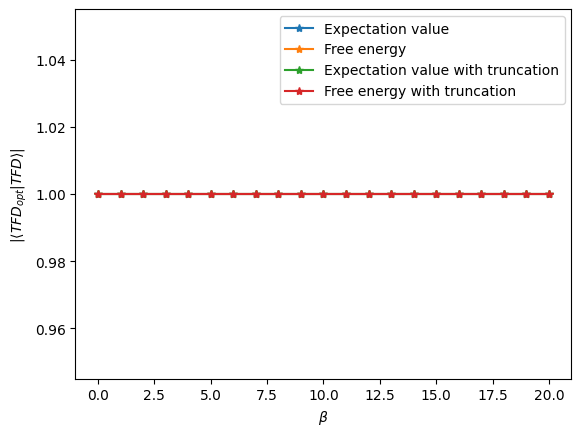

In [37]:
plt.plot(betas, results_expect, '*-', label='Expectation value')
plt.plot(betas, results_free_energy, '*-', label='Free energy')
plt.plot(betas, results_expect_trunc, '*-', label='Expectation value with truncation')
plt.plot(betas, results_free_energy_trunc, '*-', label='Free energy with truncation')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$|\langle TFD_{opt} | TFD \rangle|$')
plt.legend()
plt.show()

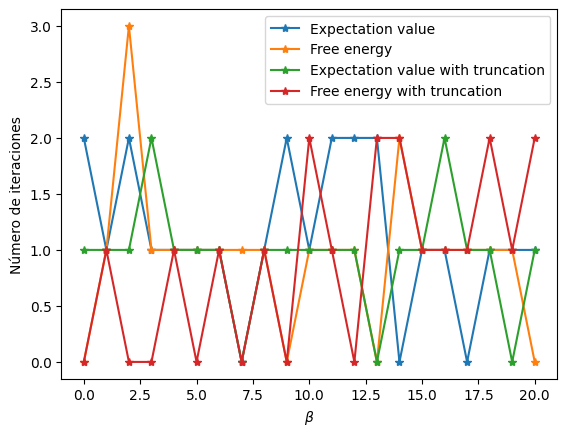

In [38]:
plt.plot(betas, niterExpect, '*-', label='Expectation value')
plt.plot(betas, niterFE, '*-', label='Free energy')
plt.plot(betas, niterExpect_trunc, '*-', label='Expectation value with truncation')
plt.plot(betas, niterFE_trunc, '*-', label='Free energy with truncation')
plt.xlabel(r'$\beta$')
plt.ylabel(r'Número de iteraciones')
plt.legend()
plt.show()

In [39]:
results_expect_trunc

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1.])

In [40]:
results_free_energy_trunc

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1.])

In [41]:
# Energías obtenidas minimizando el valor esperado de la energía en el hamiltoniano total.
np.sort(energies_expect[-1])*factor

array([-4979.9323483 , -1051.93088413,  1059.21937908,  4972.64385334])

In [42]:
# Energías obtenidas minimizando el valor esperado de la energía libre.
np.sort(energies_free_energy[-1])*factor

array([-4979.9323483 , -1051.93088413,  1059.21937908,  4972.64385334])

In [43]:
# Energías obtenidas minimizando el valor esperado de la energía en el hamiltoniano total con truncamiento de energías.
np.sort(energies_expect_trunc[-1])*factor

array([-4979.9323483 , -1051.93088413,  1059.21937908,  4972.64385334])

In [44]:
# Energías obtenidas minimizando el valor esperado de la energía libre con truncamiento de energías.
np.sort(energies_free_energy_trunc[-1])*factor

array([-4979.9323483 , -1051.93088413,  1059.21937908,  4972.64385334])

In [45]:
# Valores teóricos para las energías.
np.sort(np.linalg.eig(matrizSulfanol.to_matrix())[0])

array([-4979.9323483 +0.j, -1051.93088413+0.j,  1059.21937908+0.j,
        4972.64385334+0.j])

In [46]:
np.sort(np.linalg.eig(matrizSulfanol.to_matrix())[0])-np.sort(energies_free_energy_trunc[-1])*factor

array([-1.81898940e-12+0.j,  3.18323146e-12+0.j, -1.13686838e-12+0.j,
       -2.72848411e-12+0.j])

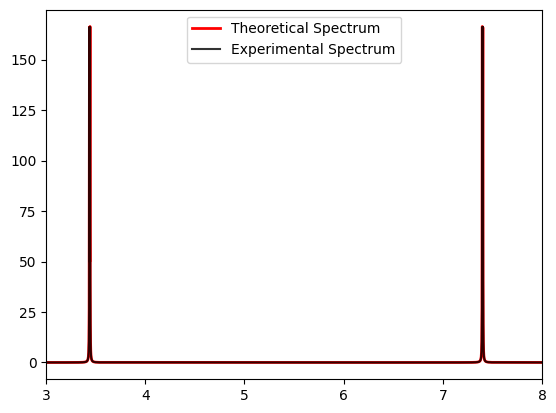

In [47]:
SW=10
d=10**5
reprSpectrum(shifts,J,d,SW,B,offset,energies_free_energy_trunc[-1]*factor,UFE_trunc[-1],xlim=[3,8])

### AB system

In [48]:
betas = np.linspace(0.001, 20.001, 21)

In [49]:
# Construimos H para el sistema AB.
offset=5
B=400
shifts=[1,1.025]
J=[10]
matrizAB=Hspin(shifts,J,offset,B)

In [50]:
print('Optimización minimizando el valor esperado de la energía en el hamiltoniano total sin truncamiento de energías.')
results_expect, energies_expect, UExpect, niterExpect, tExpect=minimize_function(matrizAB,expectation_classic,betas, trunc=False)
print('Tiempo transcurrido: '+str(tExpect)+' s.')
print('')
print('Optimización minimizando la energía libre sin truncamiento de energías.')
results_free_energy, energies_free_energy, UFE, niterFE, tFE=minimize_function(matrizAB,free_energy,betas, trunc=False)
print('Tiempo transcurrido: '+str(tFE)+' s.')
print('')
print('Optimización minimizando el valor esperado de la energía en el hamiltoniano total con truncamiento de energías.')
results_expect_trunc, energies_expect_trunc, UExpect_trunc, niterExpect_trunc, tExpect_trunc=minimize_function(matrizAB,expectation_classic,betas, trunc=True)
print('Tiempo transcurrido: '+str(tExpect_trunc)+' s.')
print('')
print('Optimización minimizando la energía libre con truncamiento de energías.')
results_free_energy_trunc, energies_free_energy_trunc, UFE_trunc, niterFE_trunc, tFE_trunc=minimize_function(matrizAB,free_energy,betas, trunc=True)
print('Tiempo transcurrido: '+str(tFE_trunc)+' s.')

Optimización minimizando el valor esperado de la energía en el hamiltoniano total sin truncamiento de energías.
Tiempo transcurrido: 2.7695200443267822 s.

Optimización minimizando la energía libre sin truncamiento de energías.
Tiempo transcurrido: 3.808743953704834 s.

Optimización minimizando el valor esperado de la energía en el hamiltoniano total con truncamiento de energías.
Beta-> m
0.001-> 4
1.001-> 4
2.001-> 3


/var/folders/jv/lqf3ggs56dz0wc8dtkz265440000gn/T/ipykernel_32175/3660231687.py:98: RuntimeWarning: overflow encountered in exp
  m=int(np.min([np.ceil(np.exp(N_sites/beta)),n]))


3.001-> 2
4.001-> 2
5.001-> 2
6.001-> 2
7.001-> 2
8.001-> 2
9.001-> 2
10.001-> 2
11.001-> 2
12.001-> 2
13.001-> 2
14.001-> 2
15.001-> 2
16.001-> 2
17.001-> 2
18.001-> 2
19.001-> 2
20.001-> 2
Tiempo transcurrido: 0.7408559322357178 s.

Optimización minimizando la energía libre con truncamiento de energías.
Beta-> m
0.001-> 4
1.001-> 4


/var/folders/jv/lqf3ggs56dz0wc8dtkz265440000gn/T/ipykernel_32175/3660231687.py:98: RuntimeWarning: overflow encountered in exp
  m=int(np.min([np.ceil(np.exp(N_sites/beta)),n]))


2.001-> 3
3.001-> 2
4.001-> 2
5.001-> 2
6.001-> 2
7.001-> 2
8.001-> 2
9.001-> 2
10.001-> 2
11.001-> 2
12.001-> 2
13.001-> 2
14.001-> 2
15.001-> 2
16.001-> 2
17.001-> 2
18.001-> 2
19.001-> 2
20.001-> 2
Tiempo transcurrido: 3.3110928535461426 s.


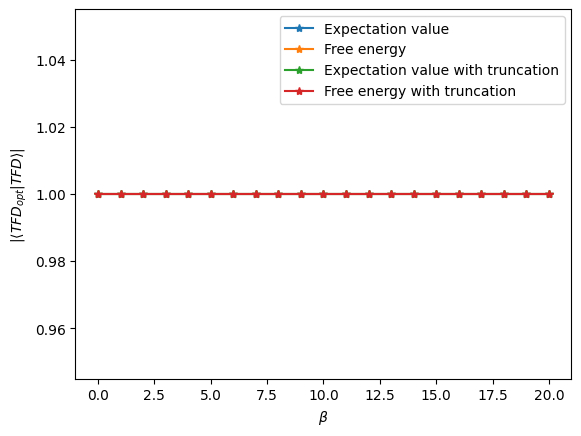

In [51]:
plt.plot(betas, results_expect, '*-', label='Expectation value')
plt.plot(betas, results_free_energy, '*-', label='Free energy')
plt.plot(betas, results_expect_trunc, '*-', label='Expectation value with truncation')
plt.plot(betas, results_free_energy_trunc, '*-', label='Free energy with truncation')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$|\langle TFD_{opt} | TFD \rangle|$')
plt.legend()
plt.show()

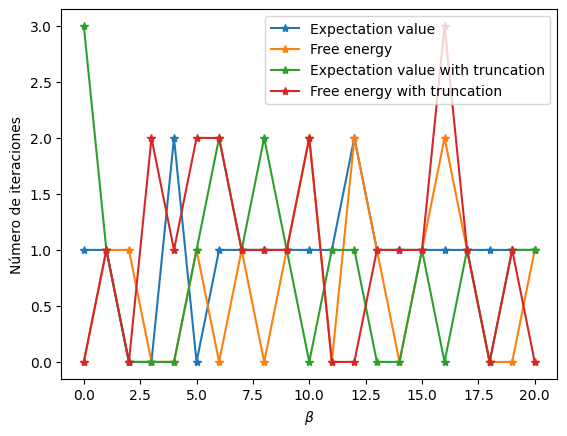

In [52]:
plt.plot(betas, niterExpect, '*-', label='Expectation value')
plt.plot(betas, niterFE, '*-', label='Free energy')
plt.plot(betas, niterExpect_trunc, '*-', label='Expectation value with truncation')
plt.plot(betas, niterFE_trunc, '*-', label='Free energy with truncation')
plt.xlabel(r'$\beta$')
plt.ylabel(r'Número de iteraciones')
plt.legend()
plt.show()

In [53]:
results_expect_trunc

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1.])

In [54]:
results_free_energy_trunc

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1.])

In [55]:
# Energías obtenidas minimizando el valor esperado de la energía en el hamiltoniano total.
np.sort(energies_expect[-1])*factor

array([-10005.97260168,    -60.13679265,     28.72086611,  10037.38852822])

In [56]:
# Energías obtenidas minimizando el valor esperado de la energía libre.
np.sort(energies_free_energy[-1])*factor

array([-10005.97260168,    -60.13679265,     28.72086611,  10037.38852822])

In [57]:
# Energías obtenidas minimizando el valor esperado de la energía en el hamiltoniano total con truncamiento de energías.
np.sort(energies_expect_trunc[-1])*factor

array([-10005.97260168,    -60.13679265,     28.72086611,  10037.38852822])

In [58]:
# Energías obtenidas minimizando el valor esperado de la energía libre con truncamiento de energías.
np.sort(energies_free_energy_trunc[-1])*factor

array([-10005.97260168,    -60.13679265,     28.72086611,  10037.38852822])

In [59]:
# Valores teóricos para las energías.
np.sort(np.linalg.eig(matrizAB.to_matrix())[0])

array([-10005.97260168+0.j,    -60.13679265+0.j,     28.72086611+0.j,
        10037.38852822+0.j])

In [60]:
np.sort(np.linalg.eig(matrizAB.to_matrix())[0])-np.sort(energies_free_energy_trunc[-1])*factor

array([ 1.81898940e-12+0.j,  1.64845915e-12+0.j, -1.33226763e-12+0.j,
       -3.63797881e-12+0.j])

In [61]:
DisplayMatrix(np.linalg.eig(matrizAB.to_matrix())[1])

\begin{bmatrix}0.00-0.00j&0.00+0.00j&1.00+0.00j&0.00+0.00j\\0.38+0.00j&0.92+0.00j&0.00+0.00j&0.00+0.00j\\0.92+0.00j&-0.38+0.00j&0.00+0.00j&0.00+0.00j\\0.00-0.00j&0.00+0.00j&0.00+0.00j&1.00+0.00j\end{bmatrix}

In [62]:
DisplayMatrix(UFE_trunc[-1])

\begin{bmatrix}-0.79-0.61j&0.00+0.00j&0.00+0.00j&0.00+0.00j\\0.00+0.00j&0.88-0.48j&0.00+0.00j&0.00+0.00j\\0.00+0.00j&0.00+0.00j&-0.95-0.30j&0.00+0.00j\\0.00+0.00j&0.00+0.00j&0.00+0.00j&0.89-0.45j\end{bmatrix}

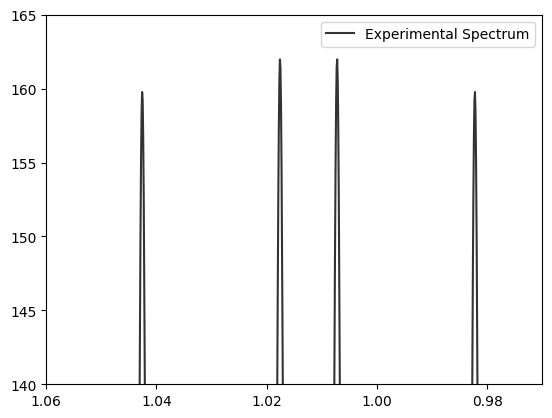

In [63]:
SW=10
d=10**5
reprSpectrum(shifts,J,d,SW,B,offset,energies_free_energy_trunc[-1]*factor,UFE_trunc[-1],xlim=[1.06,0.97],ylim=[140,165],reprteo=False)

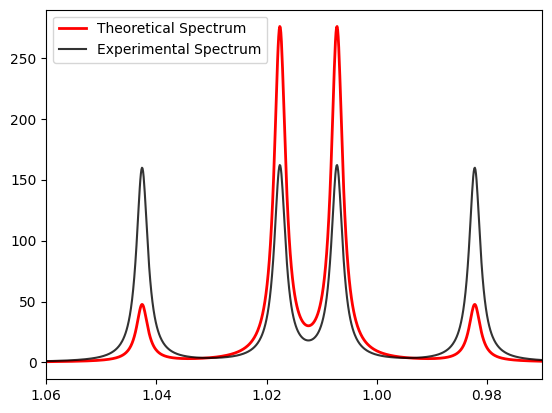

In [64]:
reprSpectrum(shifts,J,d,SW,B,offset,energies_free_energy_trunc[-1]*factor,UFE_trunc[-1],xlim=[1.06,0.97])

### AX system

In [65]:
betas = np.linspace(0.001, 20.001, 21)

In [66]:
# Construimos H para el sistema AX.
offset=5
B=400
shifts=[1,1.2]
J=[4]
matrizAX=Hspin(shifts,J,offset,B)

In [67]:
print('Optimización minimizando el valor esperado de la energía en el hamiltoniano total sin truncamiento de energías.')
results_expect, energies_expect, UExpect, niterExpect, tExpect=minimize_function(matrizAX,expectation_classic,betas, trunc=False)
print('Tiempo transcurrido: '+str(tExpect)+' s.')
print('')
print('Optimización minimizando la energía libre sin truncamiento de energías.')
results_free_energy, energies_free_energy, UFE, niterFE, tFE=minimize_function(matrizAX,free_energy,betas, trunc=False)
print('Tiempo transcurrido: '+str(tFE)+' s.')
print('')
print('Optimización minimizando el valor esperado de la energía en el hamiltoniano total con truncamiento de energías.')
results_expect_trunc, energies_expect_trunc, UExpect_trunc, niterExpect_trunc, tExpect_trunc=minimize_function(matrizAX,expectation_classic,betas, trunc=True)
print('Tiempo transcurrido: '+str(tExpect_trunc)+' s.')
print('')
print('Optimización minimizando la energía libre con truncamiento de energías.')
results_free_energy_trunc, energies_free_energy_trunc, UFE_trunc, niterFE_trunc, tFE_trunc=minimize_function(matrizAX,free_energy,betas, trunc=True)
print('Tiempo transcurrido: '+str(tFE_trunc)+' s.')

Optimización minimizando el valor esperado de la energía en el hamiltoniano total sin truncamiento de energías.
Tiempo transcurrido: 2.5205230712890625 s.

Optimización minimizando la energía libre sin truncamiento de energías.
Tiempo transcurrido: 5.298246145248413 s.

Optimización minimizando el valor esperado de la energía en el hamiltoniano total con truncamiento de energías.
Beta-> m
0.001-> 4


/var/folders/jv/lqf3ggs56dz0wc8dtkz265440000gn/T/ipykernel_32175/3660231687.py:98: RuntimeWarning: overflow encountered in exp
  m=int(np.min([np.ceil(np.exp(N_sites/beta)),n]))


1.001-> 4
2.001-> 3
3.001-> 2
4.001-> 2
5.001-> 2
6.001-> 2
7.001-> 2
8.001-> 2
9.001-> 2
10.001-> 2
11.001-> 2
12.001-> 2
13.001-> 2
14.001-> 2
15.001-> 2
16.001-> 2
17.001-> 2
18.001-> 2
19.001-> 2
20.001-> 2
Tiempo transcurrido: 2.274569272994995 s.

Optimización minimizando la energía libre con truncamiento de energías.
Beta-> m
0.001-> 4
1.001-> 4
2.001-> 3
3.001-> 2


/var/folders/jv/lqf3ggs56dz0wc8dtkz265440000gn/T/ipykernel_32175/3660231687.py:98: RuntimeWarning: overflow encountered in exp
  m=int(np.min([np.ceil(np.exp(N_sites/beta)),n]))


4.001-> 2
5.001-> 2
6.001-> 2
7.001-> 2
8.001-> 2
9.001-> 2
10.001-> 2
11.001-> 2
12.001-> 2
13.001-> 2
14.001-> 2
15.001-> 2
16.001-> 2
17.001-> 2
18.001-> 2
19.001-> 2
20.001-> 2
Tiempo transcurrido: 2.6621930599212646 s.


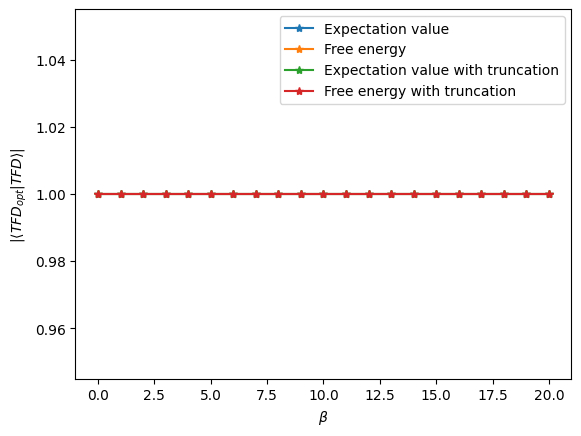

In [68]:
plt.plot(betas, results_expect, '*-', label='Expectation value')
plt.plot(betas, results_free_energy, '*-', label='Free energy')
plt.plot(betas, results_expect_trunc, '*-', label='Expectation value with truncation')
plt.plot(betas, results_free_energy_trunc, '*-', label='Free energy with truncation')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$|\langle TFD_{opt} | TFD \rangle|$')
plt.legend()
plt.show()

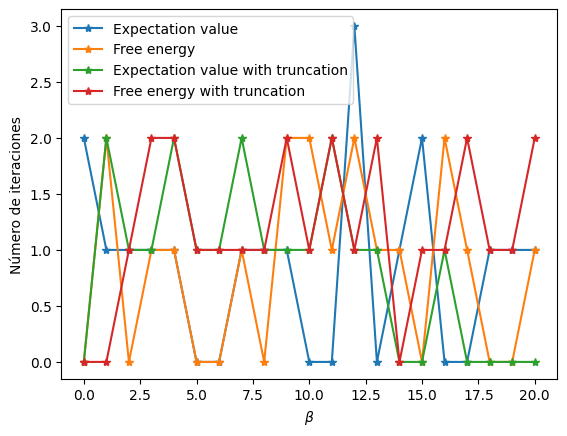

In [69]:
plt.plot(betas, niterExpect, '*-', label='Expectation value')
plt.plot(betas, niterFE, '*-', label='Free energy')
plt.plot(betas, niterExpect_trunc, '*-', label='Expectation value with truncation')
plt.plot(betas, niterFE_trunc, '*-', label='Free energy with truncation')
plt.xlabel(r'$\beta$')
plt.ylabel(r'Número de iteraciones')
plt.legend()
plt.show()

In [70]:
results_expect_trunc

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1.])

In [71]:
results_free_energy_trunc

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1.])

In [72]:
# Energías obtenidas minimizando el valor esperado de la energía en el hamiltoniano total.
np.sort(energies_expect[-1])*factor

array([-9795.48589389,  -257.92456076,   245.35819014,  9808.05226451])

In [73]:
# Energías obtenidas minimizando el valor esperado de la energía libre.
np.sort(energies_free_energy[-1])*factor

array([-9795.48589389,  -257.92456076,   245.35819014,  9808.05226451])

In [74]:
# Energías obtenidas minimizando el valor esperado de la energía en el hamiltoniano total con truncamiento de energías.
np.sort(energies_expect_trunc[-1])*factor

array([-9795.48589389,  -257.92456076,   245.35819014,  9808.05226451])

In [75]:
# Energías obtenidas minimizando el valor esperado de la energía libre con truncamiento de energías.
np.sort(energies_free_energy_trunc[-1])*factor

array([-9795.48589389,  -257.92456076,   245.35819014,  9808.05226451])

In [76]:
# Valores teóricos para las energías.
np.sort(np.linalg.eig(matrizAX.to_matrix())[0])

array([-9795.48589389+0.j,  -257.92456076+0.j,   245.35819014+0.j,
        9808.05226451+0.j])

In [77]:
DisplayMatrix(np.linalg.eig(matrizAX.to_matrix())[1])

\begin{bmatrix}0.00-0.00j&0.00+0.00j&1.00+0.00j&0.00+0.00j\\0.02+0.00j&1.00+0.00j&0.00+0.00j&0.00+0.00j\\1.00+0.00j&-0.02+0.00j&0.00+0.00j&0.00+0.00j\\0.00-0.00j&0.00+0.00j&0.00+0.00j&1.00+0.00j\end{bmatrix}

In [78]:
DisplayMatrix(UFE_trunc[-1])

\begin{bmatrix}-0.68+0.74j&0.00+0.00j&0.00+0.00j&0.00+0.00j\\0.00+0.00j&-0.99+0.12j&0.00+0.00j&0.00+0.00j\\0.00+0.00j&0.00+0.00j&-0.88-0.48j&0.00+0.00j\\0.00+0.00j&0.00+0.00j&0.00+0.00j&-0.90-0.44j\end{bmatrix}

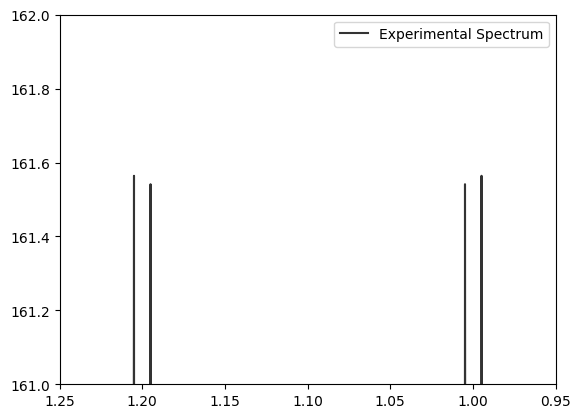

In [79]:
SW=10
d=10**5
reprSpectrum(shifts,J,d,SW,B,offset,energies_free_energy_trunc[-1]*factor,UFE_trunc[-1],xlim=[1.25,0.95],ylim=[161,162],reprteo=False)

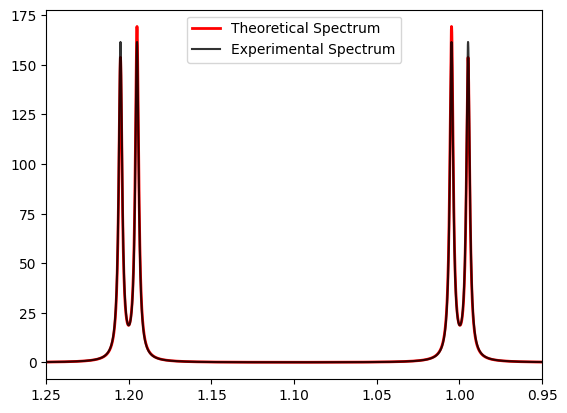

In [80]:
reprSpectrum(shifts,J,d,SW,B,offset,energies_free_energy_trunc[-1]*factor,UFE_trunc[-1],xlim=[1.25,0.95])

### AMX system

In [81]:
betas = np.linspace(0.001, 20.001, 21)

In [82]:
# Construimos H para el sistema AMX.
offset=5
B=400
shifts=[1,1.2,1.5]
J=[3,10,8]
matrizAMX=Hspin(shifts,J,offset,B)

In [83]:
print('Optimización minimizando el valor esperado de la energía en el hamiltoniano total sin truncamiento de energías.')
results_expect, energies_expect, UExpect, niterExpect, tExpect=minimize_function(matrizAMX,expectation_classic,betas, trunc=False)
print('Tiempo transcurrido: '+str(tExpect)+' s.')
print('')
print('Optimización minimizando la energía libre sin truncamiento de energías.')
results_free_energy, energies_free_energy, UFE, niterFE, tFE=minimize_function(matrizAMX,free_energy,betas, trunc=False)
print('Tiempo transcurrido: '+str(tFE)+' s.')
print('')
print('Optimización minimizando el valor esperado de la energía en el hamiltoniano total con truncamiento de energías.')
results_expect_trunc, energies_expect_trunc, UExpect_trunc, niterExpect_trunc, tExpect_trunc=minimize_function(matrizAMX,expectation_classic,betas, trunc=True)
print('Tiempo transcurrido: '+str(tExpect_trunc)+' s.')
print('')
print('Optimización minimizando la energía libre con truncamiento de energías.')
results_free_energy_trunc, energies_free_energy_trunc, UFE_trunc, niterFE_trunc, tFE_trunc=minimize_function(matrizAMX,free_energy,betas, trunc=True)
print('Tiempo transcurrido: '+str(tFE_trunc)+' s.')

Optimización minimizando el valor esperado de la energía en el hamiltoniano total sin truncamiento de energías.
Tiempo transcurrido: 54.42520093917847 s.

Optimización minimizando la energía libre sin truncamiento de energías.
Tiempo transcurrido: 85.55002903938293 s.

Optimización minimizando el valor esperado de la energía en el hamiltoniano total con truncamiento de energías.
Beta-> m
0.001-> 8


/var/folders/jv/lqf3ggs56dz0wc8dtkz265440000gn/T/ipykernel_32175/3660231687.py:98: RuntimeWarning: overflow encountered in exp
  m=int(np.min([np.ceil(np.exp(N_sites/beta)),n]))


1.001-> 8
2.001-> 5
3.001-> 3
4.001-> 3
5.001-> 2
6.001-> 2
7.001-> 2
8.001-> 2
9.001-> 2
10.001-> 2
11.001-> 2
12.001-> 2
13.001-> 2
14.001-> 2
15.001-> 2
16.001-> 2
17.001-> 2
18.001-> 2
19.001-> 2
20.001-> 2
Tiempo transcurrido: 30.69845724105835 s.

Optimización minimizando la energía libre con truncamiento de energías.
Beta-> m
0.001-> 8


/var/folders/jv/lqf3ggs56dz0wc8dtkz265440000gn/T/ipykernel_32175/3660231687.py:98: RuntimeWarning: overflow encountered in exp
  m=int(np.min([np.ceil(np.exp(N_sites/beta)),n]))


1.001-> 8
2.001-> 5
3.001-> 3
4.001-> 3
5.001-> 2
6.001-> 2
7.001-> 2
8.001-> 2
9.001-> 2
10.001-> 2


KeyboardInterrupt: 

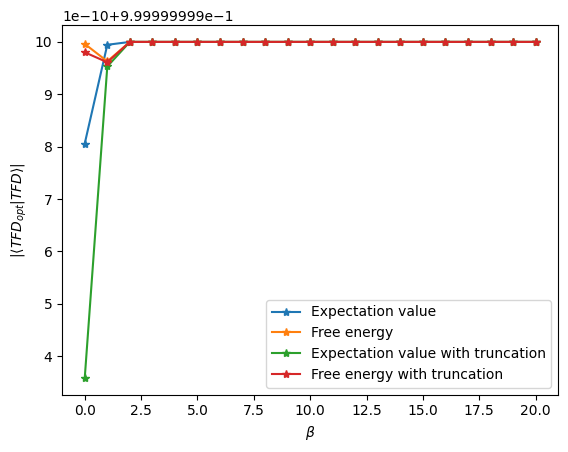

In [ ]:
plt.plot(betas, results_expect, '*-', label='Expectation value')
plt.plot(betas, results_free_energy, '*-', label='Free energy')
plt.plot(betas, results_expect_trunc, '*-', label='Expectation value with truncation')
plt.plot(betas, results_free_energy_trunc, '*-', label='Free energy with truncation')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$|\langle TFD_{opt} | TFD \rangle|$')
plt.legend()
plt.show()

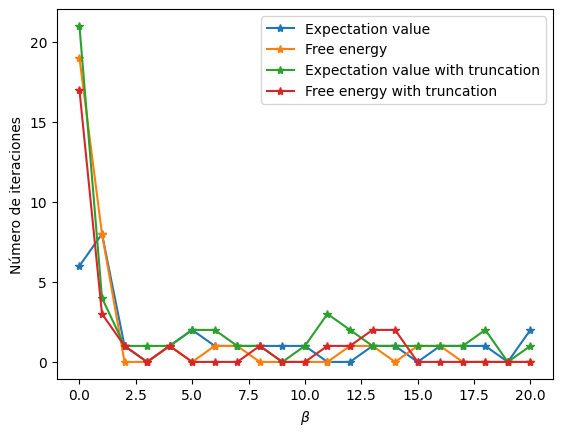

In [ ]:
plt.plot(betas, niterExpect, '*-', label='Expectation value')
plt.plot(betas, niterFE, '*-', label='Free energy')
plt.plot(betas, niterExpect_trunc, '*-', label='Expectation value with truncation')
plt.plot(betas, niterFE_trunc, '*-', label='Free energy with truncation')
plt.xlabel(r'$\beta$')
plt.ylabel(r'Número de iteraciones')
plt.legend()
plt.show()

In [ ]:
results_expect_trunc

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1.])

In [ ]:
results_free_energy_trunc

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1.])

In [ ]:
# Energías obtenidas minimizando el valor esperado de la energía en el hamiltoniano total.
np.sort(energies_expect[-1])*factor

array([-14167.01207136,  -5428.67353922,  -4650.53387587,  -4153.77810199,
         4140.81315142,   4649.51641486,   5376.68250508,  14232.98551709])

In [ ]:
# Energías obtenidas minimizando el valor esperado de la energía libre.
np.sort(energies_free_energy[-1])*factor

array([-14167.01207136,  -5428.67353922,  -4650.53387587,  -4153.77810199,
         4242.10649074,   4656.14127359,   5268.76430703,  14232.98551709])

In [ ]:
# Energías obtenidas minimizando el valor esperado de la energía en el hamiltoniano total con truncamiento de energías.
np.sort(energies_expect_trunc[-1])*factor

array([-14167.01207136,  -5428.67353922,  -4650.53387587,  -4153.77810199,
         4680.25526089,   4708.45515276,   4778.30165771,  14232.98551709])

In [ ]:
# Energías obtenidas minimizando el valor esperado de la energía libre con truncamiento de energías.
np.sort(energies_free_energy_trunc[-1])*factor

array([-14167.01207136,  -5428.67353922,  -4650.53387587,  -4153.77810199,
         4202.22338302,   4645.44574524,   5319.3429431 ,  14232.98551709])

In [ ]:
# Valores teóricos para las energías.
np.sort(np.linalg.eig(matrizAMX.to_matrix())[0])

array([-14167.01207136+0.j,  -5428.67353922+0.j,  -4650.53387587+0.j,
        -4153.77810199+0.j,   4138.10193822+0.j,   4647.26099524+0.j,
         5381.6491379 +0.j,  14232.98551709+0.j])

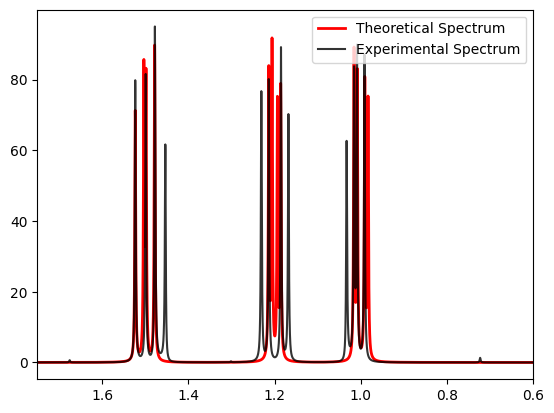

In [ ]:
d=10**5
SW=10
reprSpectrum(shifts,J,d,SW,B,offset,energies_free_energy_trunc[-1]*factor,UFE_trunc[-1],xlim=[1.75,0.6])

### ABX system

In [ ]:
betas = np.linspace(0.001, 20.001, 21)

In [ ]:
# Construimos H para el sistema ABX.
offset=5
B=400
shifts=[1,1.025,1.5]
J=[10,6,4]
matrizABX=Hspin(shifts,J,offset,B)

In [ ]:
print('Optimización minimizando el valor esperado de la energía en el hamiltoniano total sin truncamiento de energías.')
results_expect, energies_expect, UExpect, niterExpect, tExpect=minimize_function(matrizABX,expectation_classic,betas, trunc=False)
print('Tiempo transcurrido: '+str(tExpect)+' s.')
print('')
print('Optimización minimizando la energía libre sin truncamiento de energías.')
results_free_energy, energies_free_energy, UFE, niterFE, tFE=minimize_function(matrizABX,free_energy,betas, trunc=False)
print('Tiempo transcurrido: '+str(tFE)+' s.')
print('')
print('Optimización minimizando el valor esperado de la energía en el hamiltoniano total con truncamiento de energías.')
results_expect_trunc, energies_expect_trunc, UExpect_trunc, niterExpect_trunc, tExpect_trunc=minimize_function(matrizABX,expectation_classic,betas, trunc=True)
print('Tiempo transcurrido: '+str(tExpect_trunc)+' s.')
print('')
print('Optimización minimizando la energía libre con truncamiento de energías.')
results_free_energy_trunc, energies_free_energy_trunc, UFE_trunc, niterFE_trunc, tFE_trunc=minimize_function(matrizABX,free_energy,betas, trunc=True)
print('Tiempo transcurrido: '+str(tFE_trunc)+' s.')

Optimización minimizando el valor esperado de la energía en el hamiltoniano total sin truncamiento de energías.
Tiempo transcurrido: 72.37446403503418 s.

Optimización minimizando la energía libre sin truncamiento de energías.
Tiempo transcurrido: 89.7208399772644 s.

Optimización minimizando el valor esperado de la energía en el hamiltoniano total con truncamiento de energías.
Beta-> m
0.001-> 8


C:\Users\Cesar\AppData\Local\Temp\ipykernel_18284\3660231687.py:98: RuntimeWarning: overflow encountered in exp
  m=int(np.min([np.ceil(np.exp(N_sites/beta)),n]))


1.001-> 8
2.001-> 5
3.001-> 3
4.001-> 3
5.001-> 2
6.001-> 2
7.001-> 2
8.001-> 2
9.001-> 2
10.001-> 2
11.001-> 2
12.001-> 2
13.001-> 2
14.001-> 2
15.001-> 2
16.001-> 2
17.001-> 2
18.001-> 2
19.001-> 2
20.001-> 2
Tiempo transcurrido: 31.56758451461792 s.

Optimización minimizando la energía libre con truncamiento de energías.
Beta-> m
0.001-> 8


C:\Users\Cesar\AppData\Local\Temp\ipykernel_18284\3660231687.py:98: RuntimeWarning: overflow encountered in exp
  m=int(np.min([np.ceil(np.exp(N_sites/beta)),n]))


1.001-> 8
2.001-> 5
3.001-> 3
4.001-> 3
5.001-> 2
6.001-> 2
7.001-> 2
8.001-> 2
9.001-> 2
10.001-> 2
11.001-> 2
12.001-> 2
13.001-> 2
14.001-> 2
15.001-> 2
16.001-> 2
17.001-> 2
18.001-> 2
19.001-> 2
20.001-> 2
Tiempo transcurrido: 44.98270773887634 s.


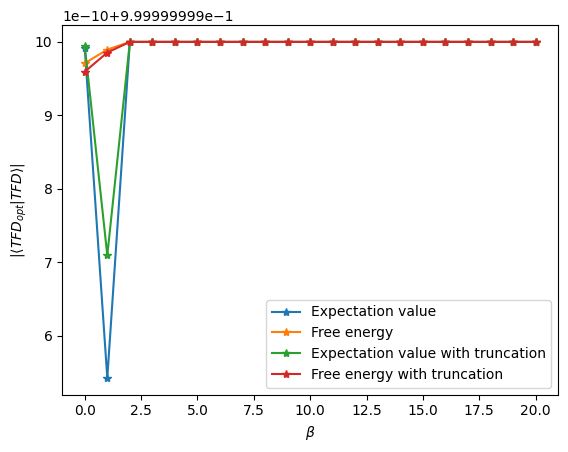

In [ ]:
plt.plot(betas, results_expect, '*-', label='Expectation value')
plt.plot(betas, results_free_energy, '*-', label='Free energy')
plt.plot(betas, results_expect_trunc, '*-', label='Expectation value with truncation')
plt.plot(betas, results_free_energy_trunc, '*-', label='Free energy with truncation')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$|\langle TFD_{opt} | TFD \rangle|$')
plt.legend()
plt.show()

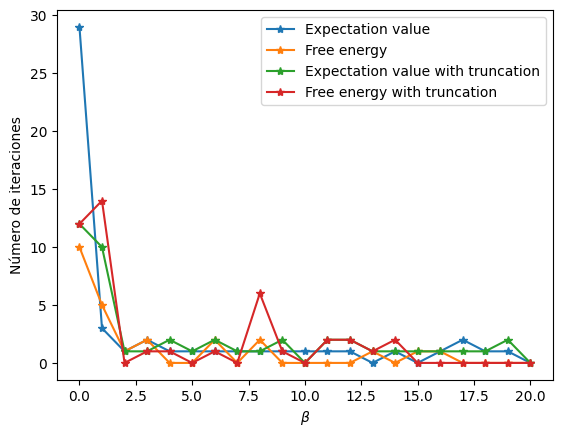

In [ ]:
plt.plot(betas, niterExpect, '*-', label='Expectation value')
plt.plot(betas, niterFE, '*-', label='Free energy')
plt.plot(betas, niterExpect_trunc, '*-', label='Expectation value with truncation')
plt.plot(betas, niterFE_trunc, '*-', label='Free energy with truncation')
plt.xlabel(r'$\beta$')
plt.ylabel(r'Número de iteraciones')
plt.legend()
plt.show()

In [ ]:
results_expect_trunc

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1.])

In [ ]:
results_free_energy_trunc

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1.])

In [ ]:
# Energías obtenidas minimizando el valor esperado de la energía en el hamiltoniano total.
np.sort(energies_expect[-1])*factor

array([-14388.49435344,  -5623.86154703,  -4456.19110702,  -4371.27355247,
         4502.16196012,   4603.15305255,   5283.17934077,  14451.32620651])

In [ ]:
# Energías obtenidas minimizando el valor esperado de la energía libre.
np.sort(energies_free_energy[-1])*factor

array([-14388.49435344,  -5623.86154703,  -4456.19110702,  -4371.27355247,
         4345.80221635,   4879.96524737,   5162.72688973,  14451.32620651])

In [ ]:
# Energías obtenidas minimizando el valor esperado de la energía en el hamiltoniano total con truncamiento de energías.
np.sort(energies_expect_trunc[-1])*factor

array([-14388.49435344,  -5623.86154703,  -4456.19110702,  -4371.27355247,
         4437.72211175,   4650.17091026,   5300.60133143,  14451.32620651])

In [ ]:
# Energías obtenidas minimizando el valor esperado de la energía libre con truncamiento de energías.
np.sort(energies_free_energy_trunc[-1])*factor

array([-14388.49435344,  -5623.86154703,  -4456.19110702,  -4371.27355247,
         4552.95286704,   4815.56006125,   5019.98142515,  14451.32620651])

In [ ]:
# Valores teóricos para las energías.
np.sort(np.linalg.eig(matrizABX.to_matrix())[0])

array([-14388.49435344+0.j,  -5623.86154703+0.j,  -4456.19110702+0.j,
        -4371.27355247+0.j,   4335.68599523+0.j,   4428.93824614+0.j,
         5623.87011207+0.j,  14451.32620651+0.j])

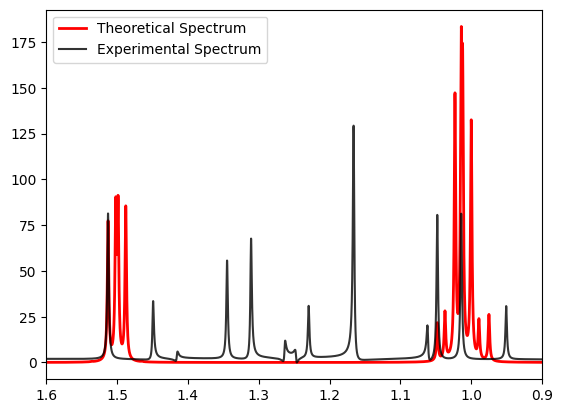

In [ ]:
d=10**5
SW=10
reprSpectrum(shifts,J,d,SW,B,offset,energies_free_energy_trunc[-1]*factor,UFE_trunc[-1],xlim=[1.6,0.9])

### ABC system

In [ ]:
betas = np.linspace(0.001, 20.001, 21)

In [ ]:
# Construimos H para el sistema ABC.
offset=5
B=400
shifts=[1,1.025,1.05]
J=[8,10,8]
matrizABC=Hspin(shifts,J,offset,B)

In [ ]:
print('Optimización minimizando el valor esperado de la energía en el hamiltoniano total sin truncamiento de energías.')
results_expect, energies_expect, UExpect, niterExpect, tExpect=minimize_function(matrizABC,expectation_classic,betas, trunc=False)
print('Tiempo transcurrido: '+str(tExpect)+' s.')
print('')
print('Optimización minimizando la energía libre sin truncamiento de energías.')
results_free_energy, energies_free_energy, UFE, niterFE, tFE=minimize_function(matrizABC,free_energy,betas, trunc=False)
print('Tiempo transcurrido: '+str(tFE)+' s.')
print('')
print('Optimización minimizando el valor esperado de la energía en el hamiltoniano total con truncamiento de energías.')
results_expect_trunc, energies_expect_trunc, UExpect_trunc, niterExpect_trunc, tExpect_trunc=minimize_function(matrizABC,expectation_classic,betas, trunc=True)
print('Tiempo transcurrido: '+str(tExpect_trunc)+' s.')
print('')
print('Optimización minimizando la energía libre con truncamiento de energías.')
results_free_energy_trunc, energies_free_energy_trunc, UFE_trunc, niterFE_trunc, tFE_trunc=minimize_function(matrizABC,free_energy,betas, trunc=True)
print('Tiempo transcurrido: '+str(tFE_trunc)+' s.')

Optimización minimizando el valor esperado de la energía en el hamiltoniano total sin truncamiento de energías.
Tiempo transcurrido: 45.798832416534424 s.

Optimización minimizando la energía libre sin truncamiento de energías.
Tiempo transcurrido: 25.22987651824951 s.

Optimización minimizando el valor esperado de la energía en el hamiltoniano total con truncamiento de energías.
Beta-> m
0.001-> 8


C:\Users\Cesar\AppData\Local\Temp\ipykernel_18284\3660231687.py:98: RuntimeWarning: overflow encountered in exp
  m=int(np.min([np.ceil(np.exp(N_sites/beta)),n]))


1.001-> 8
2.001-> 5
3.001-> 3
4.001-> 3
5.001-> 2
6.001-> 2
7.001-> 2
8.001-> 2
9.001-> 2
10.001-> 2
11.001-> 2
12.001-> 2
13.001-> 2
14.001-> 2
15.001-> 2
16.001-> 2
17.001-> 2
18.001-> 2
19.001-> 2
20.001-> 2
Tiempo transcurrido: 25.502063274383545 s.

Optimización minimizando la energía libre con truncamiento de energías.
Beta-> m
0.001-> 8


C:\Users\Cesar\AppData\Local\Temp\ipykernel_18284\3660231687.py:98: RuntimeWarning: overflow encountered in exp
  m=int(np.min([np.ceil(np.exp(N_sites/beta)),n]))


1.001-> 8
2.001-> 5
3.001-> 3
4.001-> 3
5.001-> 2
6.001-> 2
7.001-> 2
8.001-> 2
9.001-> 2
10.001-> 2
11.001-> 2
12.001-> 2
13.001-> 2
14.001-> 2
15.001-> 2
16.001-> 2
17.001-> 2
18.001-> 2
19.001-> 2
20.001-> 2
Tiempo transcurrido: 16.30810856819153 s.


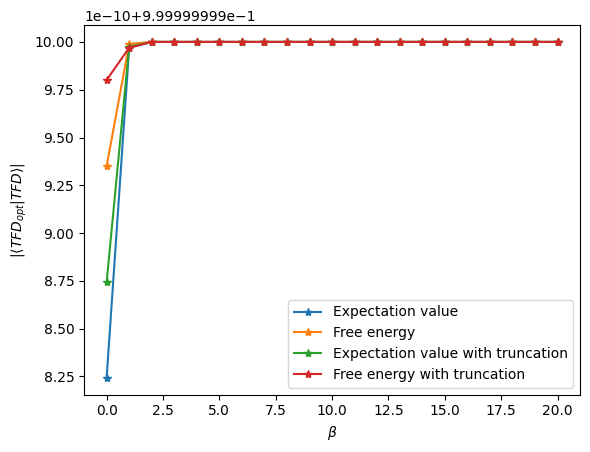

In [ ]:
plt.plot(betas, results_expect, '*-', label='Expectation value')
plt.plot(betas, results_free_energy, '*-', label='Free energy')
plt.plot(betas, results_expect_trunc, '*-', label='Expectation value with truncation')
plt.plot(betas, results_free_energy_trunc, '*-', label='Free energy with truncation')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$|\langle TFD_{opt} | TFD \rangle|$')
plt.legend()
plt.show()

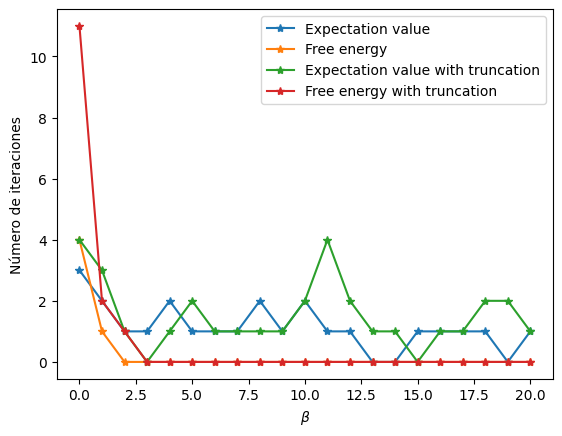

In [ ]:
plt.plot(betas, niterExpect, '*-', label='Expectation value')
plt.plot(betas, niterFE, '*-', label='Free energy')
plt.plot(betas, niterExpect_trunc, '*-', label='Expectation value with truncation')
plt.plot(betas, niterFE_trunc, '*-', label='Free energy with truncation')
plt.xlabel(r'$\beta$')
plt.ylabel(r'Número de iteraciones')
plt.legend()
plt.show()

In [ ]:
results_expect_trunc

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1.])

In [ ]:
results_free_energy_trunc

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1.])

In [ ]:
# Energías obtenidas minimizando el valor esperado de la energía en el hamiltoniano total.
np.sort(energies_expect[-1])*factor

array([-14944.55625313,  -5085.75050383,  -5012.24343415,  -4928.24372415,
         4918.94557156,   5008.84803399,   5016.76264757,  15026.23766212])

In [ ]:
# Energías obtenidas minimizando el valor esperado de la energía libre.
np.sort(energies_free_energy[-1])*factor

array([-14944.55625313,  -5085.75050383,  -5012.24343415,  -4928.24372415,
         4972.4717254 ,   4977.56173491,   4994.52279281,  15026.23766212])

In [ ]:
# Energías obtenidas minimizando el valor esperado de la energía en el hamiltoniano total con truncamiento de energías.
np.sort(energies_expect_trunc[-1])*factor

array([-14944.55625313,  -5085.75050383,  -5012.24343415,  -4928.24372415,
         4928.99308435,   4967.16798129,   5048.39518749,  15026.23766212])

In [ ]:
# Energías obtenidas minimizando el valor esperado de la energía libre con truncamiento de energías.
np.sort(energies_free_energy_trunc[-1])*factor

array([-14944.55625313,  -5085.75050383,  -5012.24343415,  -4928.24372415,
         4927.26601009,   5002.18073621,   5015.10950683,  15026.23766212])

In [ ]:
# Valores teóricos para las energías.
np.sort(np.linalg.eig(matrizABC.to_matrix())[0])

array([-14944.55625313+0.j,  -5085.75050383+0.j,  -5012.24343415+0.j,
        -4928.24372415+0.j,   4904.51413459+0.j,   4978.02120427+0.j,
         5062.02091427+0.j,  15026.23766212+0.j])

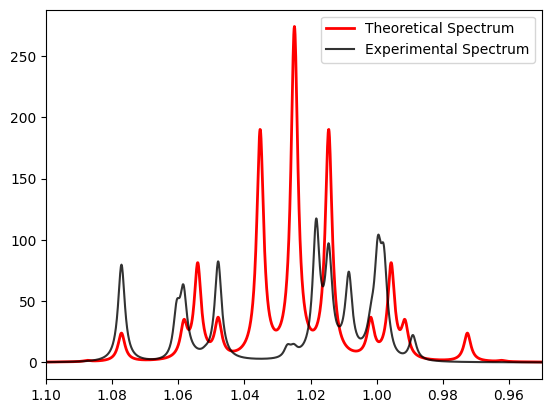

In [ ]:
d=10**5
SW=10
reprSpectrum(shifts,J,d,SW,B,offset,energies_free_energy[-1]*factor,UFE[-1],xlim=[1.1,0.95])

### AMPX system

In [ ]:
betas = [8]

In [ ]:
# Construimos H para el sistema AMPX.
offset=0
B=400
shifts=[1,1.3,2,2.5]
J=[10,7,2,15,9,20]
matrizAMPX=Hspin(shifts,J,offset,B)

In [ ]:
print('Optimización minimizando el valor esperado de la energía en el hamiltoniano total sin truncamiento de energías.')
results_expect, energies_expect, UExpect, niterExpect, tExpect=minimize_function(matrizAMPX,expectation_classic,betas, trunc=False)
print('Tiempo transcurrido: '+str(tExpect)+' s.')
print('')
print('Optimización minimizando la energía libre sin truncamiento de energías.')
results_free_energy, energies_free_energy, UFE, niterFE, tFE=minimize_function(matrizAMPX,free_energy,betas, trunc=False)
print('Tiempo transcurrido: '+str(tFE)+' s.')
print('')
print('Optimización minimizando el valor esperado de la energía en el hamiltoniano total con truncamiento de energías.')
results_expect_trunc, energies_expect_trunc, UExpect_trunc, niterExpect_trunc, tExpect_trunc=minimize_function(matrizAMPX,expectation_classic,betas, trunc=True)
print('Tiempo transcurrido: '+str(tExpect_trunc)+' s.')
print('')
print('Optimización minimizando la energía libre con truncamiento de energías.')
results_free_energy_trunc, energies_free_energy_trunc, UFE_trunc, niterFE_trunc, tFE_trunc=minimize_function(matrizAMPX,free_energy,betas, trunc=True)
print('Tiempo transcurrido: '+str(tFE_trunc)+' s.')

Optimización minimizando el valor esperado de la energía en el hamiltoniano total sin truncamiento de energías.
Tiempo transcurrido: 50.24866485595703 s.

Optimización minimizando la energía libre sin truncamiento de energías.
Tiempo transcurrido: 52.62466812133789 s.

Optimización minimizando el valor esperado de la energía en el hamiltoniano total con truncamiento de energías.
Beta-> m
8-> 2
Tiempo transcurrido: 39.06470322608948 s.

Optimización minimizando la energía libre con truncamiento de energías.
Beta-> m
8-> 2
Tiempo transcurrido: 23.378270149230957 s.


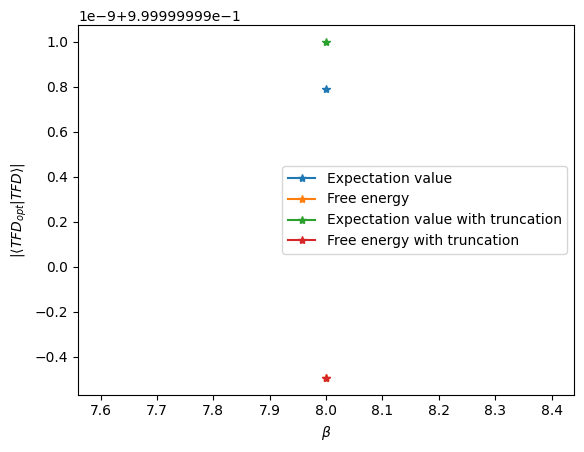

In [ ]:
plt.plot(betas, results_expect, '*-', label='Expectation value')
plt.plot(betas, results_free_energy, '*-', label='Free energy')
plt.plot(betas, results_expect_trunc, '*-', label='Expectation value with truncation')
plt.plot(betas, results_free_energy_trunc, '*-', label='Free energy with truncation')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$|\langle TFD_{opt} | TFD \rangle|$')
plt.legend()
plt.show()

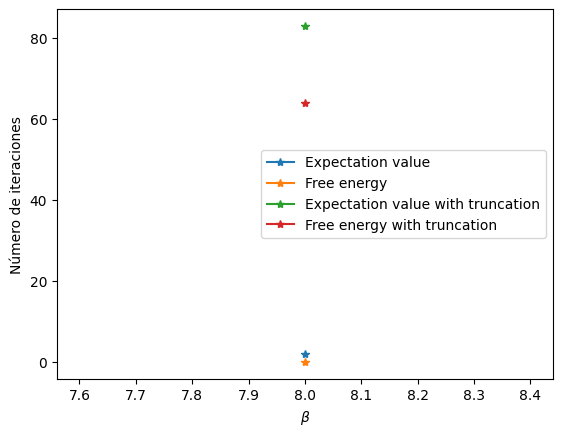

In [ ]:
plt.plot(betas, niterExpect, '*-', label='Expectation value')
plt.plot(betas, niterFE, '*-', label='Free energy')
plt.plot(betas, niterExpect_trunc, '*-', label='Expectation value with truncation')
plt.plot(betas, niterFE_trunc, '*-', label='Free energy with truncation')
plt.xlabel(r'$\beta$')
plt.ylabel(r'Número de iteraciones')
plt.legend()
plt.show()

In [ ]:
results_expect

array([1.])

In [ ]:
results_free_energy

array([1.])

In [ ]:
# Energías obtenidas minimizando el valor esperado de la energía en el hamiltoniano total.
np.sort(energies_expect[-1])*factor

array([-8446.17184894, -5906.599555  , -4762.51388909, -3637.20516772,
       -2783.94542374,  -861.81973654,  -442.85648599,  -315.0307831 ,
          88.10605419,   550.81707796,   782.86353612,  2909.50982645,
        3983.43950401,  4624.90368184,  5572.41102325,  8644.09218629])

In [ ]:
# Energías obtenidas minimizando el valor esperado de la energía libre.
np.sort(energies_free_energy[-1])*factor

array([-8446.17184894, -4821.44286012, -4820.10488049, -4715.26100482,
       -2733.45529012,  -556.93230011,  -406.75659287,  -246.5692699 ,
        -112.2617911 ,   495.21320715,   629.38640948,  3640.13227545,
        3930.12865237,  4625.34257624,  4894.66053149,  8644.09218629])

In [ ]:
# Energías obtenidas minimizando el valor esperado de la energía en el hamiltoniano total con truncamiento de energías.
np.sort(energies_expect_trunc[-1])*factor

array([-8446.17184894, -5993.37535479, -5284.78882556, -3554.01487521,
       -2258.08497999, -1518.98469229,  -398.39800565,  -298.71084581,
        -283.3999115 ,   207.45209541,  2094.12102248,  2260.06760705,
        3487.37908585,  5270.22319344,  6072.59414921,  8644.09218629])

In [ ]:
# Energías obtenidas minimizando el valor esperado de la energía libre con truncamiento de energías.
np.sort(energies_free_energy_trunc[-1])*factor

array([-8446.17184894, -4780.42260366, -4766.89646292, -4474.6171048 ,
       -3068.32786417, -1520.7402472 ,  -476.41109385,   158.57514219,
         178.21313061,   432.77271798,  1029.6700129 ,  2260.08165016,
        3896.65108115,  5270.10827285,  5663.42303139,  8644.09218629])

In [ ]:
# Valores teóricos para las energías.
np.sort(np.linalg.eig(matrizAMPX.to_matrix())[0])

array([-8446.17184918+0.j, -5994.14903683+0.j, -5285.90427429+0.j,
       -3553.20868453+0.j, -2771.03297639+0.j, -2257.00203988+0.j,
       -1057.26863451+0.j,  -298.71906901+0.j,   207.73507448+0.j,
         959.73571379+0.j,  2260.06760694+0.j,  2761.62955447+0.j,
        3487.32163529+0.j,  5270.28064407+0.j,  6072.59414922+0.j,
        8644.09218635+0.j])

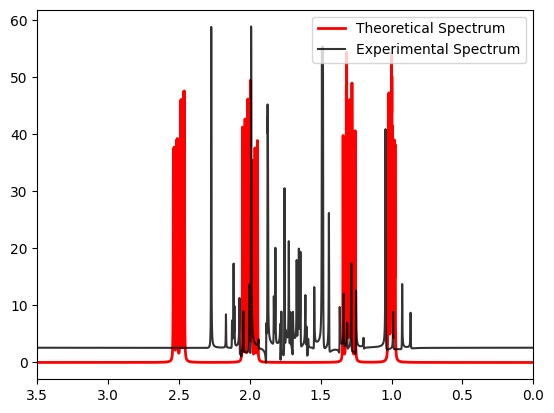

In [ ]:
d=10**5
SW=10
reprSpectrum(shifts,J,d,SW,B,offset,energies_free_energy[-1]*factor,UFE[-1],xlim=[3.5,0])

### AA'MM'X system

In [ ]:
betas = [8]

In [ ]:
# Construimos H para el sistema AA'MM'X.
offset=5
B=400
shifts=[5,5,5.4,5.4,6]
J=[100,20,25,5,35,30,9,200,40,45]
matrizAA2MM2X=Hspin(shifts,J,offset,B)

In [ ]:
print('Optimización minimizando el valor esperado de la energía en el hamiltoniano total sin truncamiento de energías.')
results_expect, energies_expect, UExpect, niterExpect, tExpect=minimize_function(matrizAA2MM2X,expectation_classic,betas, trunc=False)
print('Tiempo transcurrido: '+str(tExpect)+' s.')
print('')
print('Optimización minimizando la energía libre sin truncamiento de energías.')
results_free_energy, energies_free_energy, UFE, niterFE, tFE=minimize_function(matrizAA2MM2X,free_energy,betas, trunc=False)
print('Tiempo transcurrido: '+str(tFE)+' s.')
print('')
print('Optimización minimizando el valor esperado de la energía en el hamiltoniano total con truncamiento de energías.')
results_expect_trunc, energies_expect_trunc, UExpect_trunc, niterExpect_trunc, tExpect_trunc=minimize_function(matrizAA2MM2X,expectation_classic,betas, trunc=True)
print('Tiempo transcurrido: '+str(tExpect_trunc)+' s.')
print('')
print('Optimización minimizando la energía libre con truncamiento de energías.')
results_free_energy_trunc, energies_free_energy_trunc, UFE_trunc, niterFE_trunc, tFE_trunc=minimize_function(matrizAA2MM2X,free_energy,betas, trunc=True)
print('Tiempo transcurrido: '+str(tFE_trunc)+' s.')

Optimización minimizando el valor esperado de la energía en el hamiltoniano total sin truncamiento de energías.
Tiempo transcurrido: 4937.922164916992 s.

Optimización minimizando la energía libre sin truncamiento de energías.
Tiempo transcurrido: 4229.674691200256 s.

Optimización minimizando el valor esperado de la energía en el hamiltoniano total con truncamiento de energías.
Beta-> m
8-> 2
Tiempo transcurrido: 440.0437340736389 s.

Optimización minimizando la energía libre con truncamiento de energías.
Beta-> m
8-> 2
Tiempo transcurrido: 191.1285798549652 s.


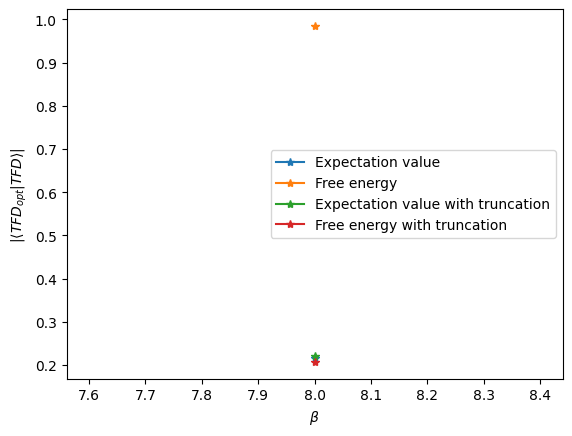

In [ ]:
plt.plot(betas, results_expect, '*-', label='Expectation value')
plt.plot(betas, results_free_energy, '*-', label='Free energy')
plt.plot(betas, results_expect_trunc, '*-', label='Expectation value with truncation')
plt.plot(betas, results_free_energy_trunc, '*-', label='Free energy with truncation')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$|\langle TFD_{opt} | TFD \rangle|$')
plt.legend()
plt.show()

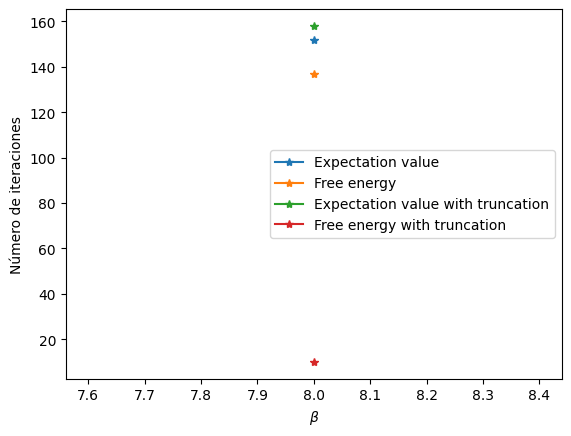

In [ ]:
plt.plot(betas, niterExpect, '*-', label='Expectation value')
plt.plot(betas, niterFE, '*-', label='Free energy')
plt.plot(betas, niterExpect_trunc, '*-', label='Expectation value with truncation')
plt.plot(betas, niterFE_trunc, '*-', label='Free energy with truncation')
plt.xlabel(r'$\beta$')
plt.ylabel(r'Número de iteraciones')
plt.legend()
plt.show()

In [ ]:
results_expect

array([0.21600184])

In [ ]:
results_free_energy

array([0.98485071])

In [ ]:
# Energías obtenidas minimizando el valor esperado de la energía en el hamiltoniano total.
np.sort(energies_expect[-1])*factor

array([-2.28982343e+03, -1.46736664e+03, -1.10739668e+03, -9.35562435e+02,
       -8.84636145e+02, -7.84715472e+02, -7.41491608e+02, -6.74063218e+02,
       -6.65886215e+02, -6.13528273e+02, -5.69817125e+02, -3.53029933e+02,
       -3.49181252e+02, -2.33428983e+02, -1.92207562e+02, -1.55495279e+02,
        2.35035841e+00,  3.68517912e+01,  6.99558786e+01,  7.83587840e+01,
        2.02122332e+02,  3.58316708e+02,  3.67595826e+02,  5.94719190e+02,
        6.40160436e+02,  6.96932547e+02,  7.12177265e+02,  1.12604348e+03,
        1.49751838e+03,  1.58544376e+03,  1.62297928e+03,  2.42610423e+03])

In [ ]:
# Energías obtenidas minimizando el valor esperado de la energía libre.
np.sort(energies_free_energy[-1])*factor

array([-2670.30028645, -2213.06410515, -1719.35910495, -1199.61295455,
       -1122.95755923,  -929.55382385,  -888.50142371,  -766.55044466,
        -563.06254719,  -386.21380448,  -339.97608232,  -189.10019132,
        -158.77863518,   -67.49881477,   -47.36825453,     6.71363799,
          77.0807679 ,    98.32399453,   117.65836278,   172.61810797,
         233.21217796,   301.09035229,   305.1283583 ,   571.67170062,
         588.72512407,   717.50845188,   955.7566265 ,  1193.93965038,
        1416.0773898 ,  1570.33348944,  2283.44225069,  2652.61758925])

In [ ]:
# Energías obtenidas minimizando el valor esperado de la energía en el hamiltoniano total con truncamiento de energías.
np.sort(energies_expect_trunc[-1])*factor

array([-2289.75288044, -1456.9766627 , -1333.16230612, -1145.57276335,
        -924.42402796,  -741.49564449,  -645.78105064,  -645.47126237,
        -607.87316284,  -577.11585386,  -466.00501704,  -458.74966444,
        -429.53379339,  -349.74010435,  -299.87679568,   -15.71615048,
          96.94351354,   158.86574073,   212.62742248,   311.2751029 ,
         444.36764661,   466.63039789,   488.10384873,   531.05532591,
         542.77498459,   573.72091325,   657.54841398,   707.87463936,
         866.1680709 ,  1696.22190917,  2070.32248941,  2562.74672071])

In [ ]:
# Energías obtenidas minimizando el valor esperado de la energía libre con truncamiento de energías.
np.sort(energies_free_energy_trunc[-1])*factor

array([-1770.76591839, -1524.74780733, -1278.12178531, -1092.16776656,
       -1084.37135623, -1007.37867724,  -866.91585828,  -737.58348048,
        -589.61654818,  -536.30794834,  -460.32570564,  -386.29180253,
        -301.96505267,  -258.99610284,  -171.11181716,  -166.29743148,
         -88.84811792,   -26.65005944,    10.73381748,   108.81664571,
         182.77576103,   184.79365134,   206.87963333,   287.66875981,
         352.92703749,   485.67766692,   575.21350478,  1194.74618398,
        1680.87117451,  1688.62407669,  2667.2982207 ,  2721.43710222])

In [ ]:
# Valores teóricos para las energías.
np.sort(np.linalg.eig(matrizAA2MM2X.to_matrix())[0])

array([-2671.16799623+0.j, -2289.83386065+0.j, -2064.73171903+0.j,
       -2042.86777602+0.j, -2019.28078708+0.j, -1881.15102868+0.j,
       -1686.36134564+0.j, -1462.41138025+0.j, -1437.97058809+0.j,
        -870.18099194+0.j,  -822.20712396+0.j,  -755.23959896+0.j,
        -560.26468625+0.j,  -157.508379  +0.j,   -45.73521399+0.j,
         -16.10845732+0.j,    95.77252786+0.j,   213.41043546+0.j,
         440.95985422+0.j,   450.43584448+0.j,   471.72258102+0.j,
         493.57600948+0.j,   589.75392364+0.j,   764.41079091+0.j,
        1122.32788973+0.j,  1741.40378296+0.j,  1742.8215996 +0.j,
        1754.05433433+0.j,  2239.83502476+0.j,  2705.32190092+0.j,
        2895.73239279+0.j,  3061.48204092+0.j])

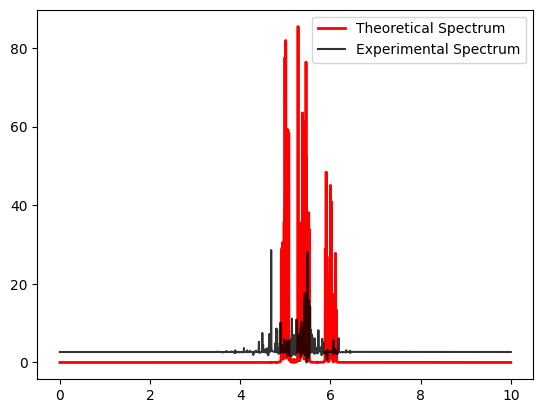

In [ ]:
SW=10
d=10**5
reprSpectrum(shifts,J,d,SW,B,offset,energies_free_energy[-1]*factor,UFE[-1])